In [45]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os

import arviz as az
import matplotlib.pyplot as plt
import neuromodels as nm
import numpy as np
import pandas as pd
import pylfi
import quantities as pq
import scipy.stats as stats
import seaborn as sns

from elephant.conversion import BinnedSpikeTrain
from elephant.spike_train_correlation import correlation_coefficient
from tqdm import tqdm_notebook as tqdm
from utils import *
from viziphant.rasterplot import rasterplot_rates
from viziphant.spike_train_correlation import plot_corrcoef

In [46]:
# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

# Set fontsizes in figures
size = 10
tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": size,
    "font.size": size,
    "legend.fontsize": size,
    "xtick.labelsize": size-1,
    "ytick.labelsize": size-1,
    'legend.handlelength': 2
}

plt.rcParams.update(tex_fonts)
plt.rc('text', usetex=True)

# Set path to save the figures
FIGURE_PATH = "./../latex/figures" 
TABLE_PATH = "./../latex/tables" 

def fig_path(fig_id):
    """
    Input name of figure to load or save with extension as dtype str
    """
    return os.path.join(FIGURE_PATH + "/", fig_id)


def tab_path(tab_id):
    """
    Input name of table to load or save with extension as dtype str
    """
    return os.path.join(TABLE_PATH + "/", tab_id)


def df_to_latex(df, outfile):
    """
    Render dataframe to a LaTeX tabular environment table and write to file
    """
    n = len(df.columns)
    col_format = n * 'c'
    # Render dataframe to a LaTeX tabular environment table and write to file
    pd.options.display.float_format = '{:,.3f}'.format
    df = df.apply(lambda x: x.astype(
        int) if np.allclose(x, x.astype(int)) else x)
    pd.options.display.latex.escape = False
    latex = df.to_latex(index=False, column_format=col_format)
    latex = latex.replace('\\toprule', '\\hline \\hline')
    latex = latex.replace('\\midrule', '\\hline \\hline')
    latex = latex.replace('\\bottomrule', '\\hline \\hline')

    with open(tab_path(outfile), 'w') as f:
        f.write(latex)

# Set figure size
pt = 410 #360

def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

fs = set_size(pt, fraction=1)
print(fs)

(5.673170056731701, 3.5062119190183605)


In [47]:
path = "data/"

# Brunel Network Model AI State Inference

## Observed data

In [48]:
# Experimental setup parameters 

order = 2500    # -> NE=10,000 ; NI=2500 ; N_tot=12,500 ; CE=1000 ; CI=250
epsilon = 0.1   # connection probability
D = 1.5         # synaptic delay (ms)
T = 1000        # simulation time (ms)
N_rec = 20      # record output from N_rec neurons
n_type = 'exc'  # record excitatory spike trains
J = 0.1         # excitatory synapse weight (mV)

# ground truth
eta_ai = 2.       # range [1.5, 4], use uniform prior
g_ai = 5.          # range [4, 8], use uniform prior

# In phase diagram:
# g = 4 corresponds to balance between excitation and inhibition
# eta = 1 corresponds to input sufficient to reach firing threshold

In [49]:
# load observed data
spiketrains = load_spiketrain('data/obs_ai_data.pkl')

# statistics calculator
s_stats = ["mean_firing_rate",  # rate estimation
           "mean_cv",           # spike interval statistic
           "fanofactor"         # statistic across spike trains
           ]

t_start = 100. * pq.ms
t_stop = T * pq.ms

sts = nm.statistics.SpikeTrainStats(stats=s_stats,
                                    t_start=t_start,
                                    t_stop=t_stop
                                    )

sum_stats = sts(spiketrains)

for s, r in zip(s_stats, sum_stats):
    print(f'{s}: {r}')

mean_firing_rate: 0.03661111111111111
mean_cv: 0.42506007658105566
fanofactor: 0.23413793103448277


### Raster and rate plot

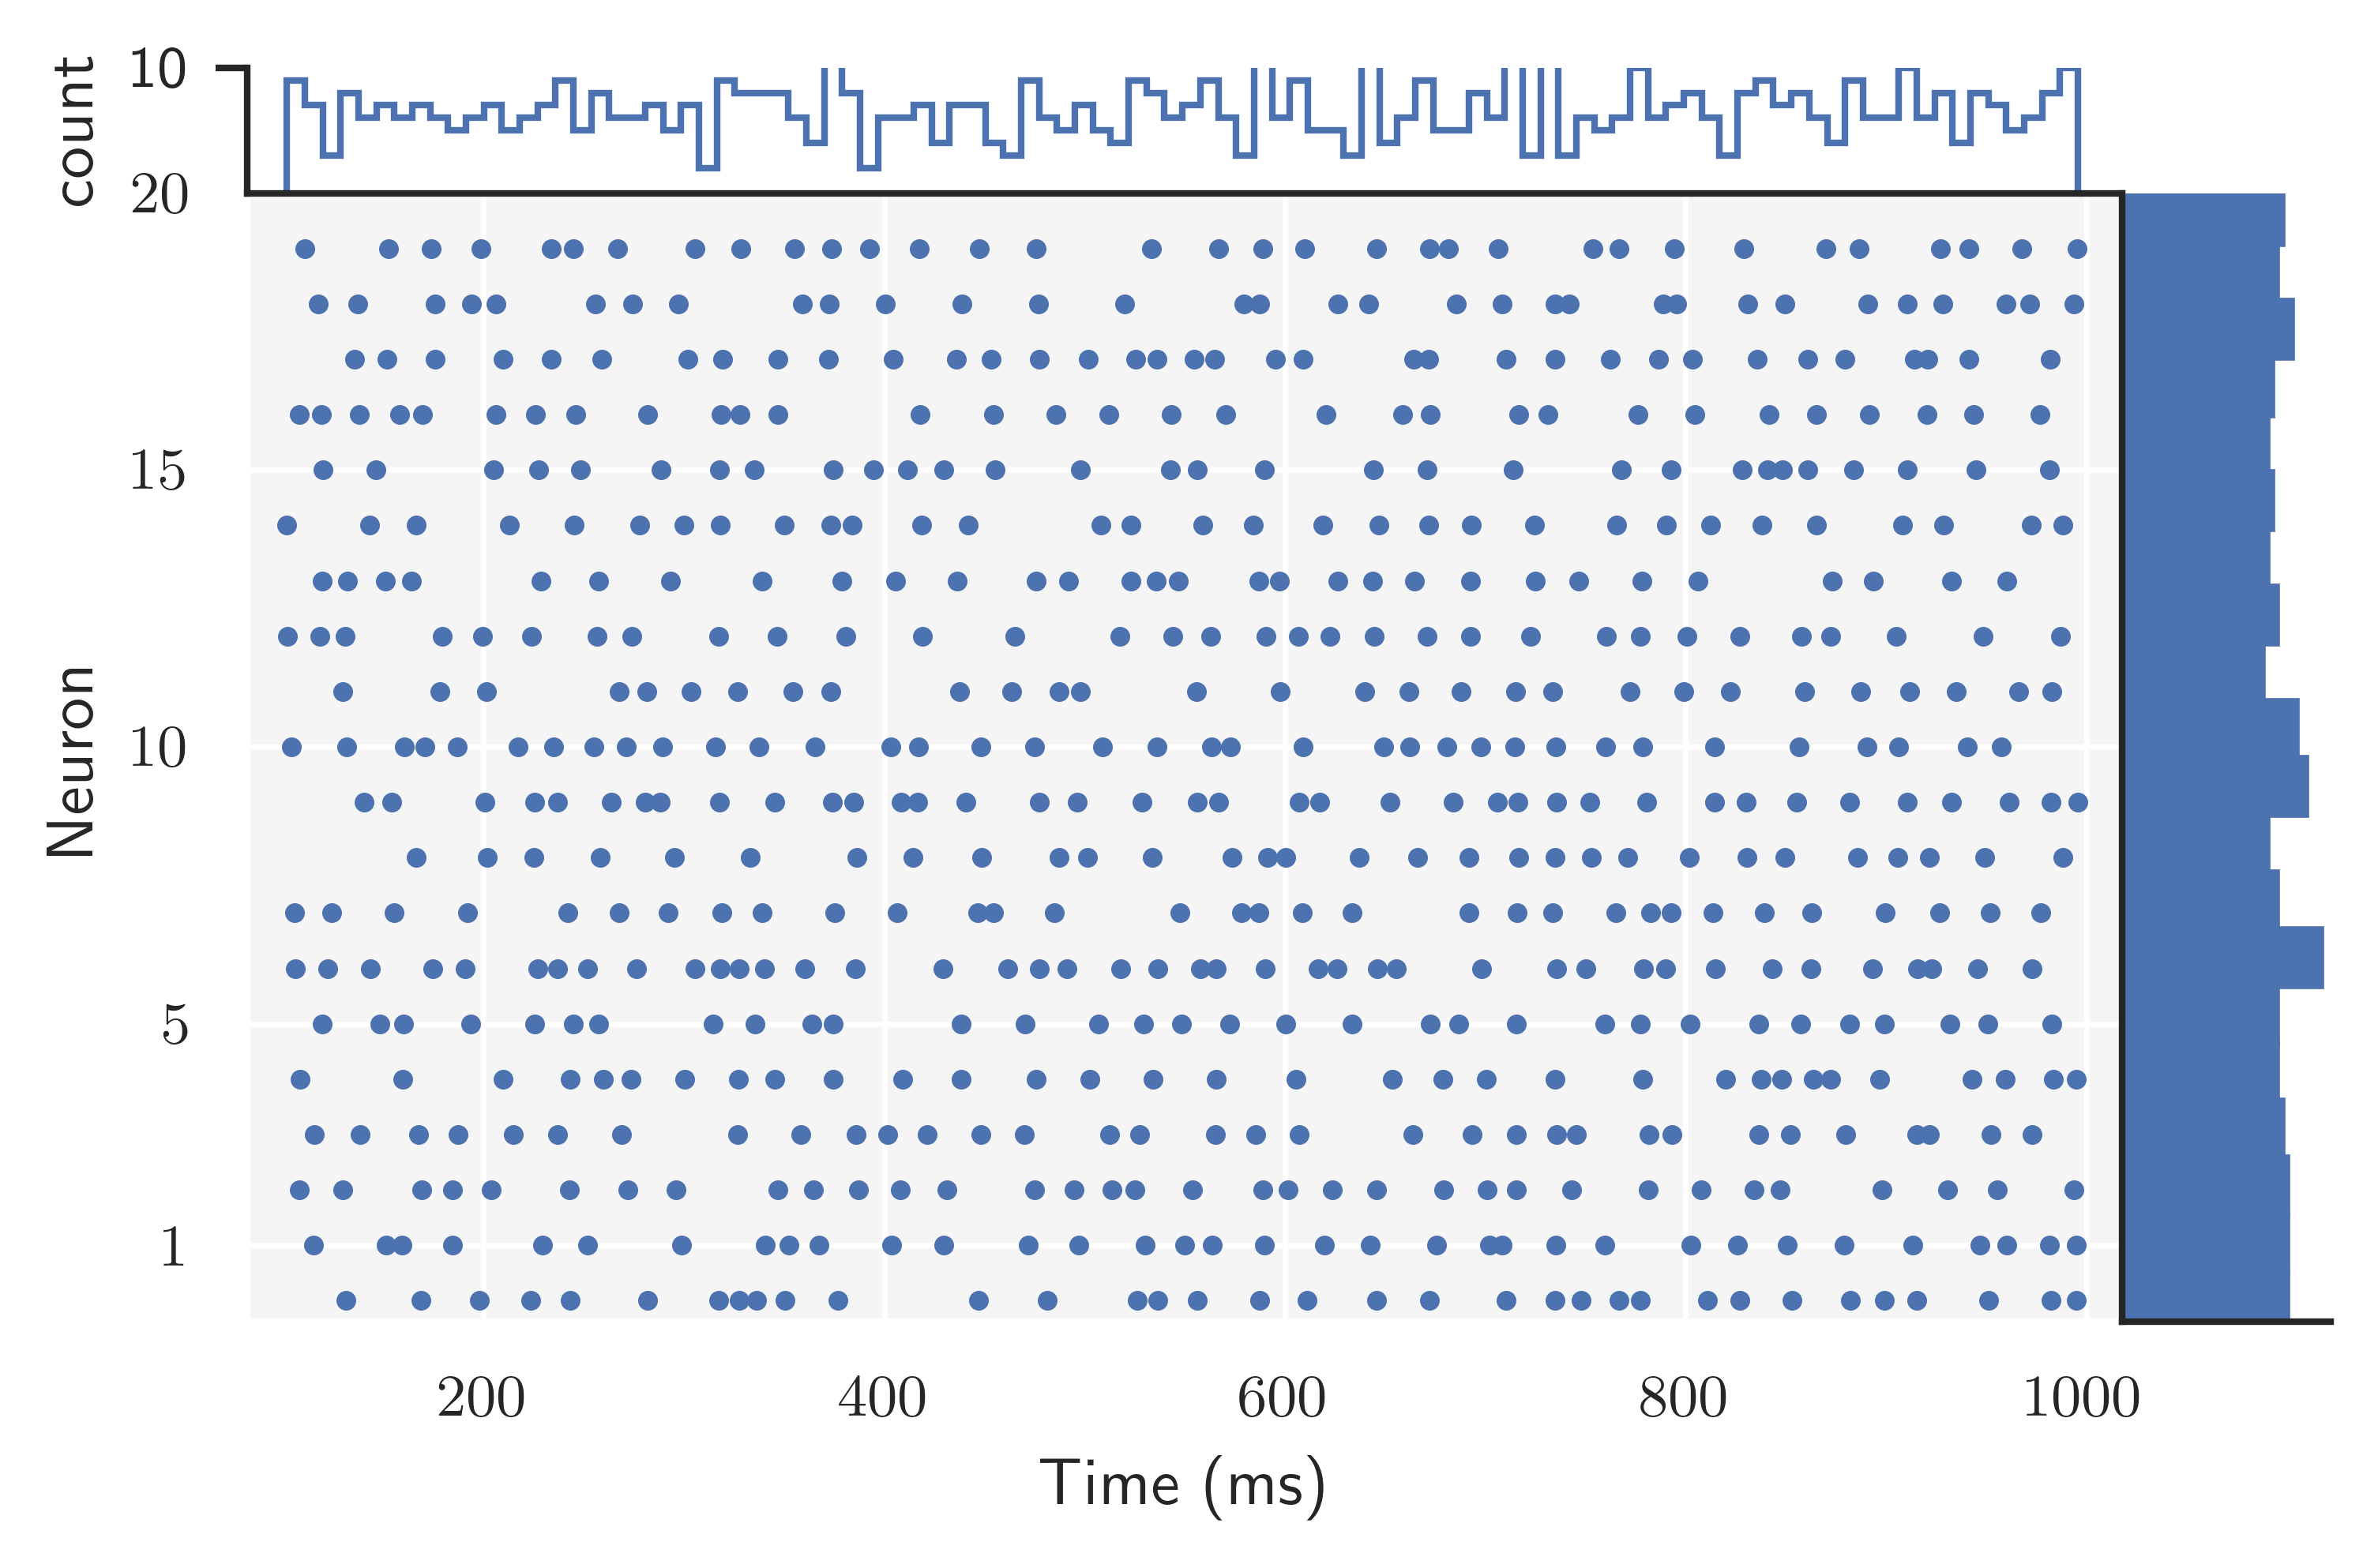

In [50]:
t_start = 100. * pq.ms
t_stop = T * pq.ms

spiketrains_slice = slice_spiketrains(spiketrains,
                                      t_start=t_start,
                                      t_stop=t_stop
                                      )

fig, ax = plt.subplots(figsize=fs,
                       constrained_layout=True,
                       dpi=300
                       )


rasterplot_rates(spiketrains_slice, ax=ax)
ax.set(yticks=[1, 5, 10, 15, 20],
       ylabel='Neuron'
       )

fig.savefig(fig_path('brunel_obs_ai.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

### Correlation matrix

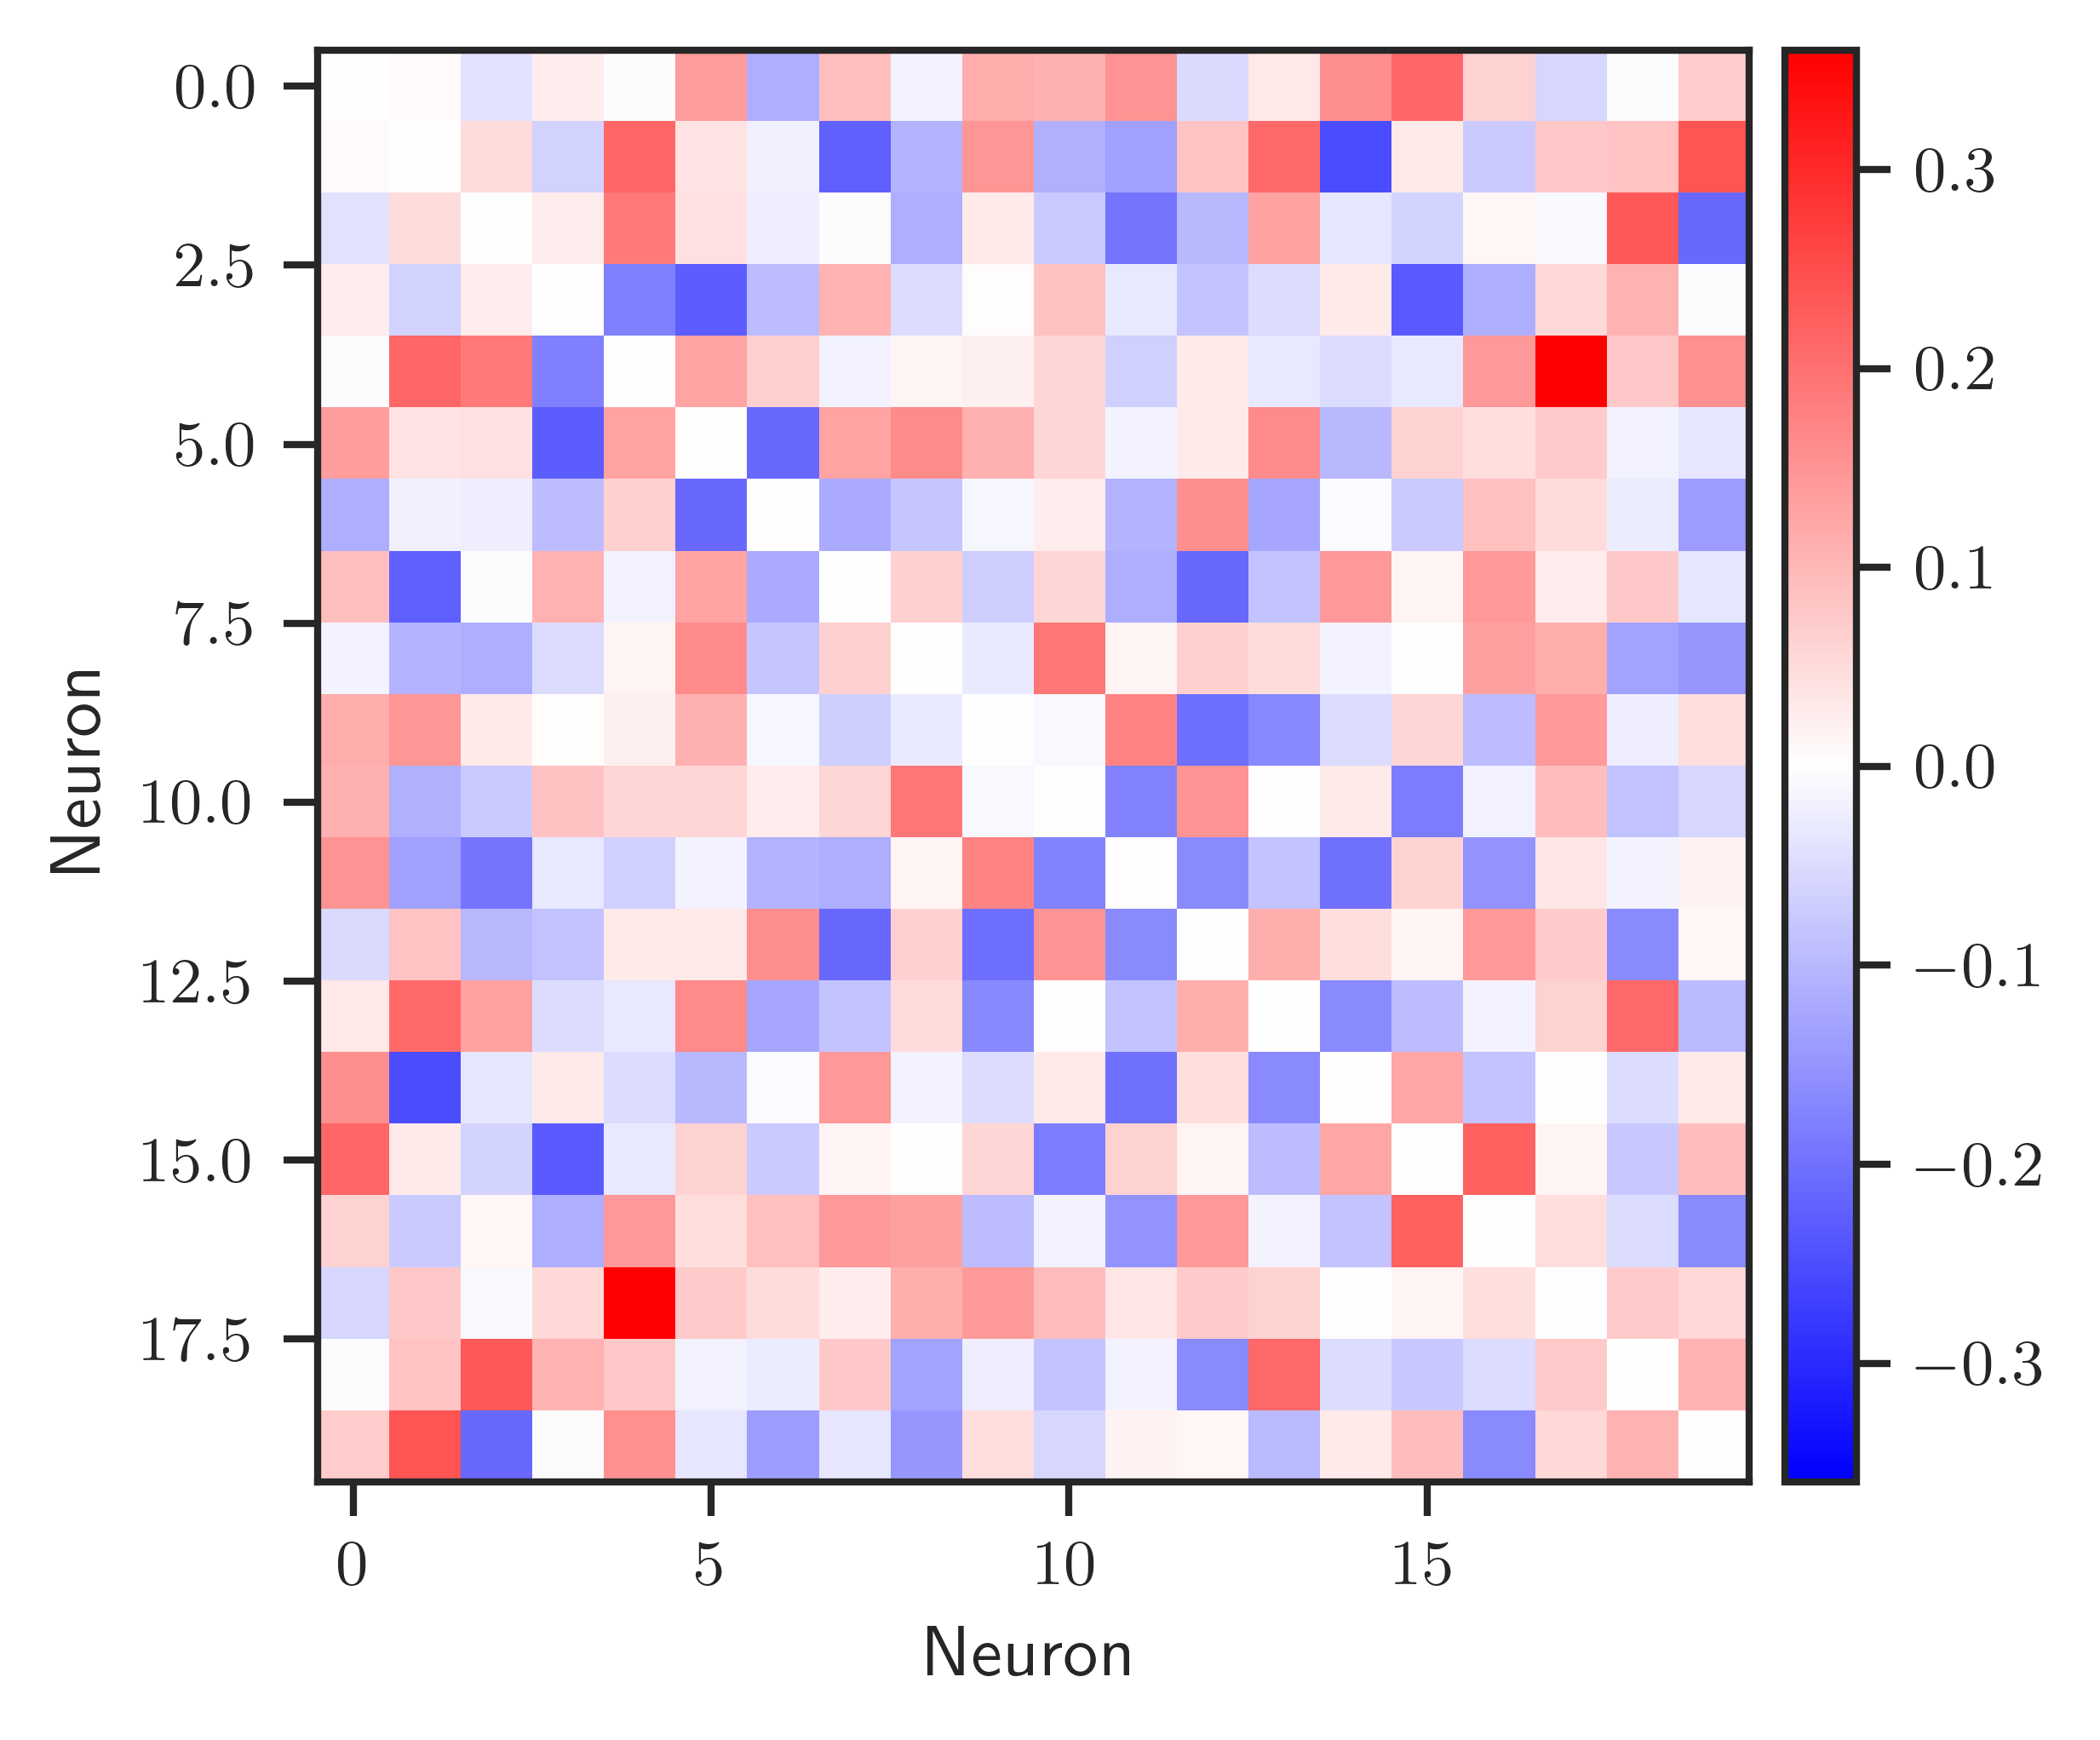

In [51]:
binned_spiketrains = BinnedSpikeTrain(spiketrains_slice, bin_size=10 * pq.ms)
corrcoef_matrix = correlation_coefficient(binned_spiketrains)

fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)

plot_corrcoef(corrcoef_matrix, axes=ax)

ax.set(xlabel='Neuron',
       ylabel='Neuron',
       #title='Correlation coefficient matrix'
       )

fig.savefig(fig_path('brunel_obs_corr.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

## Priors

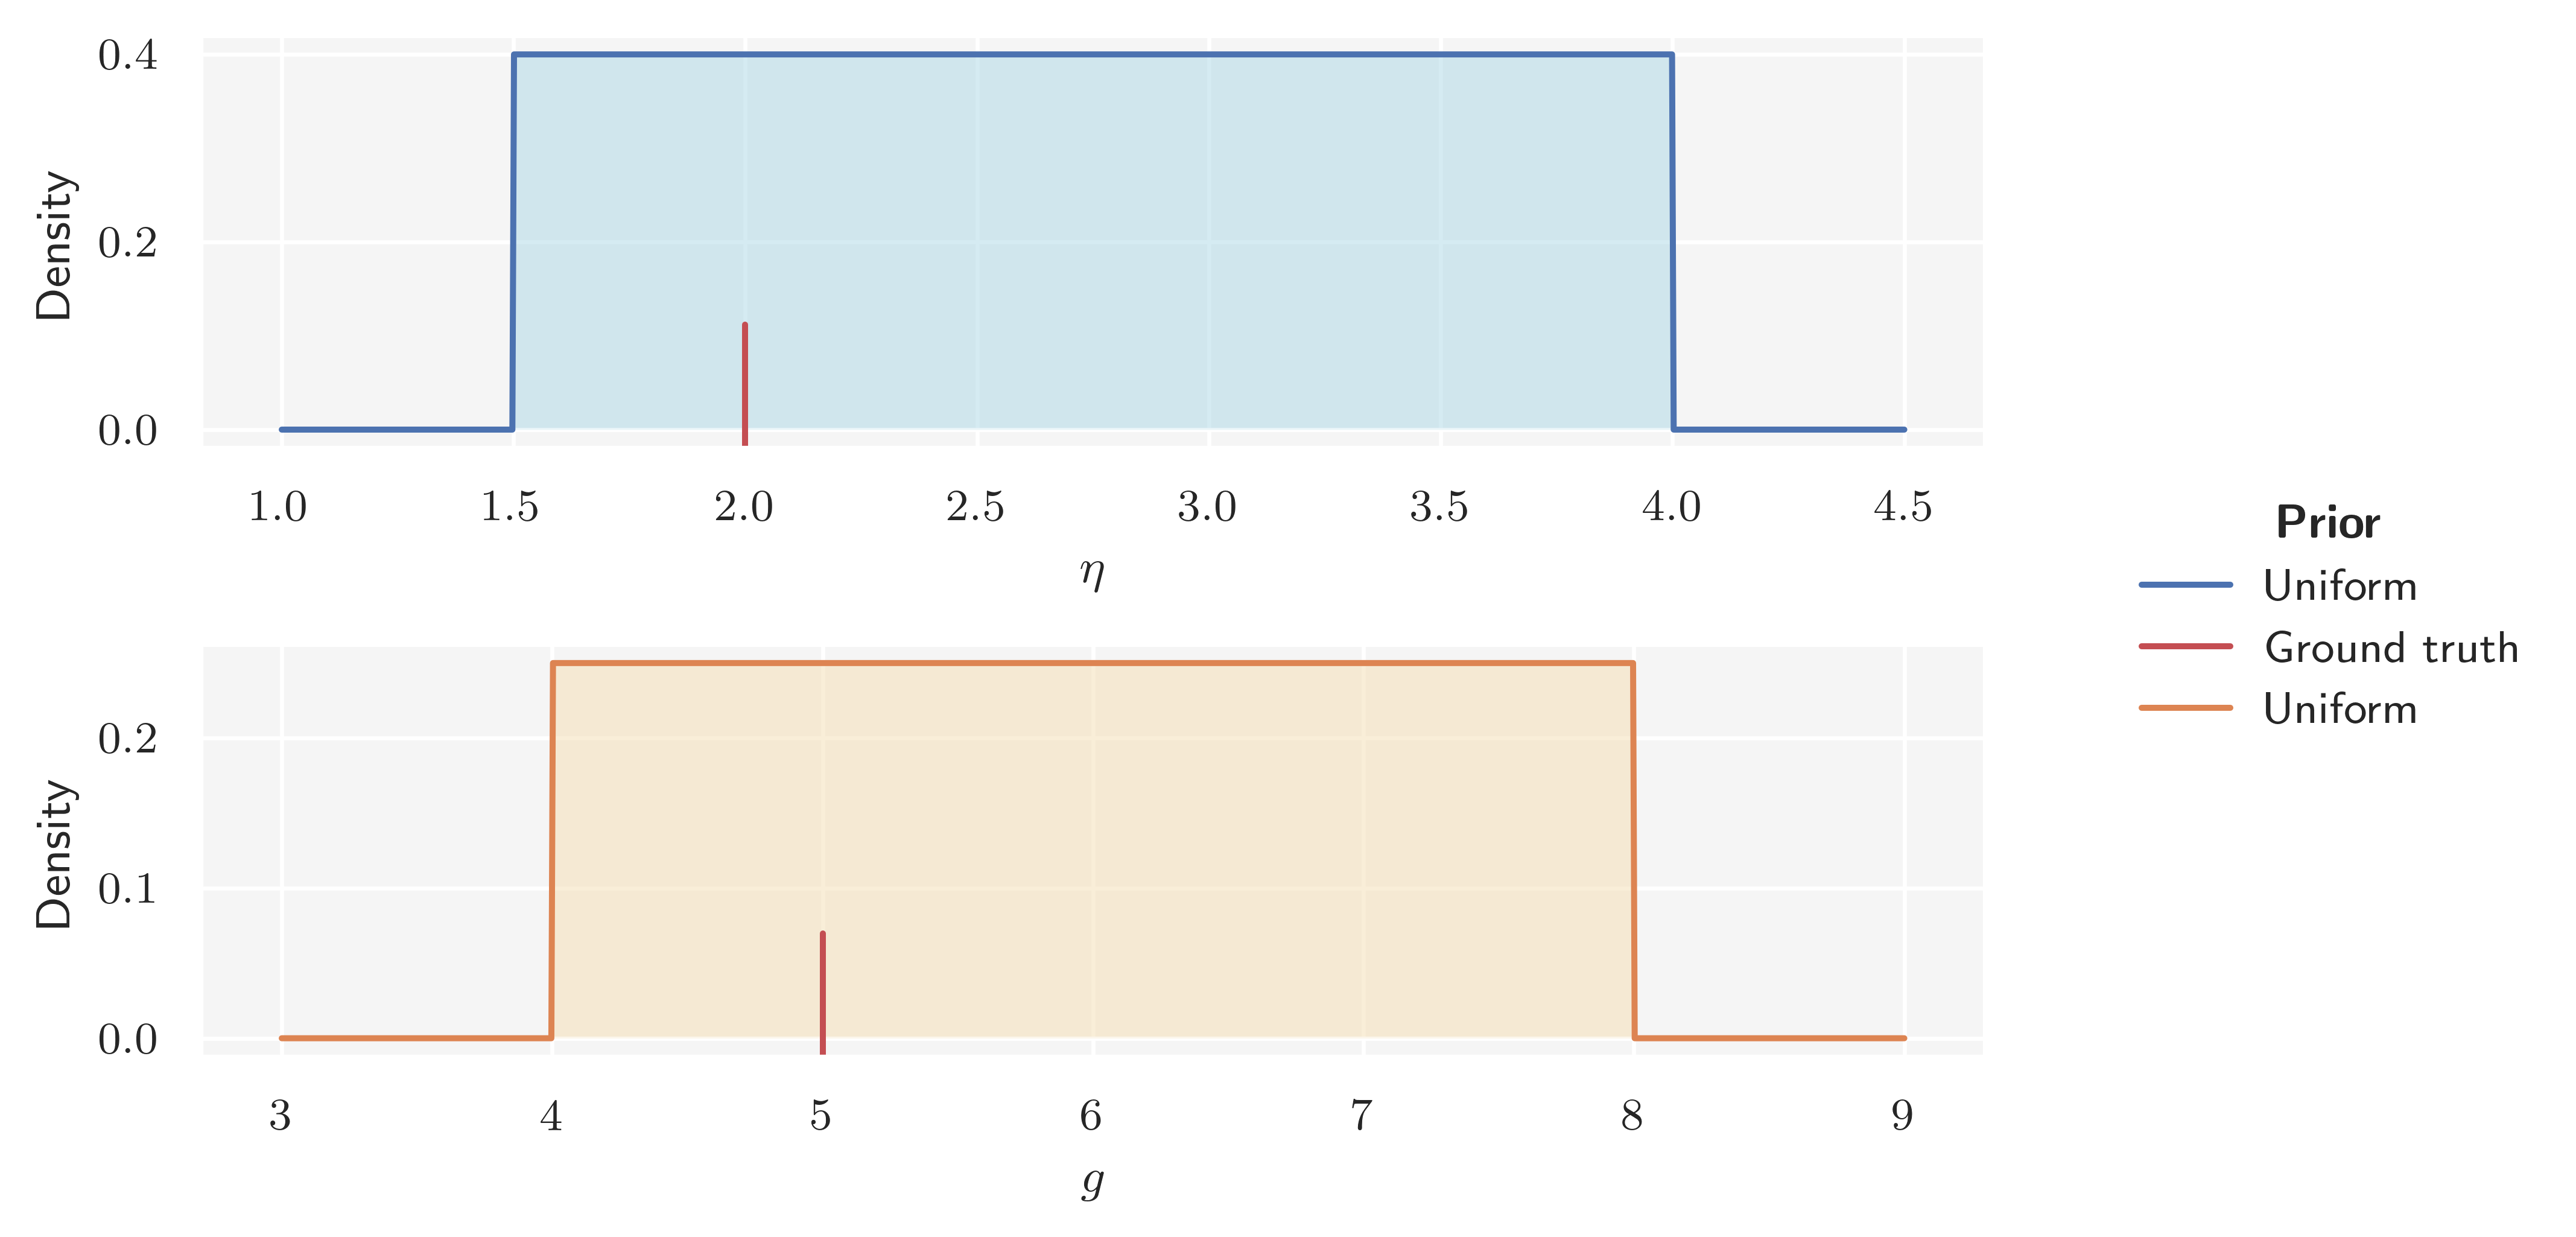

In [52]:
# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

eta_prior = pylfi.Prior('uniform',
                        loc=1.5,
                        scale=2.5,
                        name='eta',
                        tex=r"$\eta$"
                        )

g_prior = pylfi.Prior('uniform',
                      loc=4,
                      scale=4,
                      name='g',
                      tex=r"$g$"
                      )

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=fs, tight_layout=True, dpi=300)

ax1 = axes[0]
x = np.linspace(1, 4.5, 1000)
eta_prior.plot_prior(x, ax=ax1, label='Uniform')
ax1.axvline(eta_ai, ymax=0.3, color='r', label='Ground truth')
g, = ax1.plot([1], [0], color='C1', alpha=1, label='Uniform')

ax2 = axes[1]
x = np.linspace(3, 9, 1000)
g_prior.plot_prior(x, ax=ax2, color='C1', facecolor='wheat')
ax2.axvline(g_ai, ymax=0.3, color='r')

handles, labels = ax1.get_legend_handles_labels()

fig.legend(handles,
          labels,
          loc='center left',
          bbox_to_anchor=(1.04, 0.5),
          fancybox=True,
          borderaxespad=0.1,
          frameon=False,
          title=r"\textbf{Prior}",
          ncol=1
         )

fig.savefig(fig_path('brunel_priors.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

## Simulation

In [53]:
df = pd.read_csv('data/brunel_ai_data.csv')
df

,eta,g,$\eta$,$g$,mean_firing_rate,mean_cv,fanofactor
0,2.139653,6.040061,2.139653,6.040061,0.023944,0.549996,0.341667
1,1.768176,7.335284,1.768176,7.335284,0.011611,0.615821,0.283333
2,3.504035,5.147253,3.504035,5.147253,0.072833,0.443488,0.188276
3,3.067462,5.867245,3.067462,5.867245,0.043278,0.569711,0.323256
4,2.244444,4.588072,2.244444,4.588072,0.060722,0.353803,0.085153
...,...,...,...,...,...,...,...
1995,2.123932,4.667643,2.123932,4.667643,0.053667,0.379671,0.106657
1996,3.668498,4.704150,3.668498,4.704150,0.103167,0.325364,0.147708
1997,2.725004,7.344014,2.725004,7.344014,0.024000,0.722976,0.628891
1998,1.808409,6.152027,1.808409,6.152027,0.018000,0.568184,0.324504


### Check for missing values

In [54]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.isna().sum().to_frame("NaN count")

,NaN count
eta,0
g,0
$\eta$,0
$g$,0
mean_firing_rate,0
mean_cv,0
fanofactor,0


### Look at summary statistics

In [55]:
df.columns

Index(['eta', 'g', '$\eta$', '$g$', 'mean_firing_rate', 'mean_cv',
       'fanofactor'],
      dtype='object')

In [56]:
selected_columns = df[['$\eta$', '$g$', 'mean_firing_rate', 'mean_cv', 'fanofactor']]
df_stats = selected_columns.copy()
df_stats.rename(columns={"mean_firing_rate": "Mean firing rate",
                   "mean_cv": "Mean CV",
                   "fanofactor": "Fano factor"
                  },
          inplace=True
         )

df_stats

,$\eta$,$g$,Mean firing rate,Mean CV,Fano factor
0,2.139653,6.040061,0.023944,0.549996,0.341667
1,1.768176,7.335284,0.011611,0.615821,0.283333
2,3.504035,5.147253,0.072833,0.443488,0.188276
3,3.067462,5.867245,0.043278,0.569711,0.323256
4,2.244444,4.588072,0.060722,0.353803,0.085153
...,...,...,...,...,...
1995,2.123932,4.667643,0.053667,0.379671,0.106657
1996,3.668498,4.704150,0.103167,0.325364,0.147708
1997,2.725004,7.344014,0.024000,0.722976,0.628891
1998,1.808409,6.152027,0.018000,0.568184,0.324504


In [57]:
df_stats = df_stats.iloc[:len(df_stats.index)//4]  # plot subset only
df_stats

,$\eta$,$g$,Mean firing rate,Mean CV,Fano factor
0,2.139653,6.040061,0.023944,0.549996,0.341667
1,1.768176,7.335284,0.011611,0.615821,0.283333
2,3.504035,5.147253,0.072833,0.443488,0.188276
3,3.067462,5.867245,0.043278,0.569711,0.323256
4,2.244444,4.588072,0.060722,0.353803,0.085153
...,...,...,...,...,...
495,3.416425,4.954923,0.078944,0.403432,0.144275
496,3.135454,4.220128,0.132611,0.230601,0.083447
497,3.927176,7.061968,0.042556,1.098724,1.148229
498,3.788145,4.193933,0.163722,0.199150,0.022847


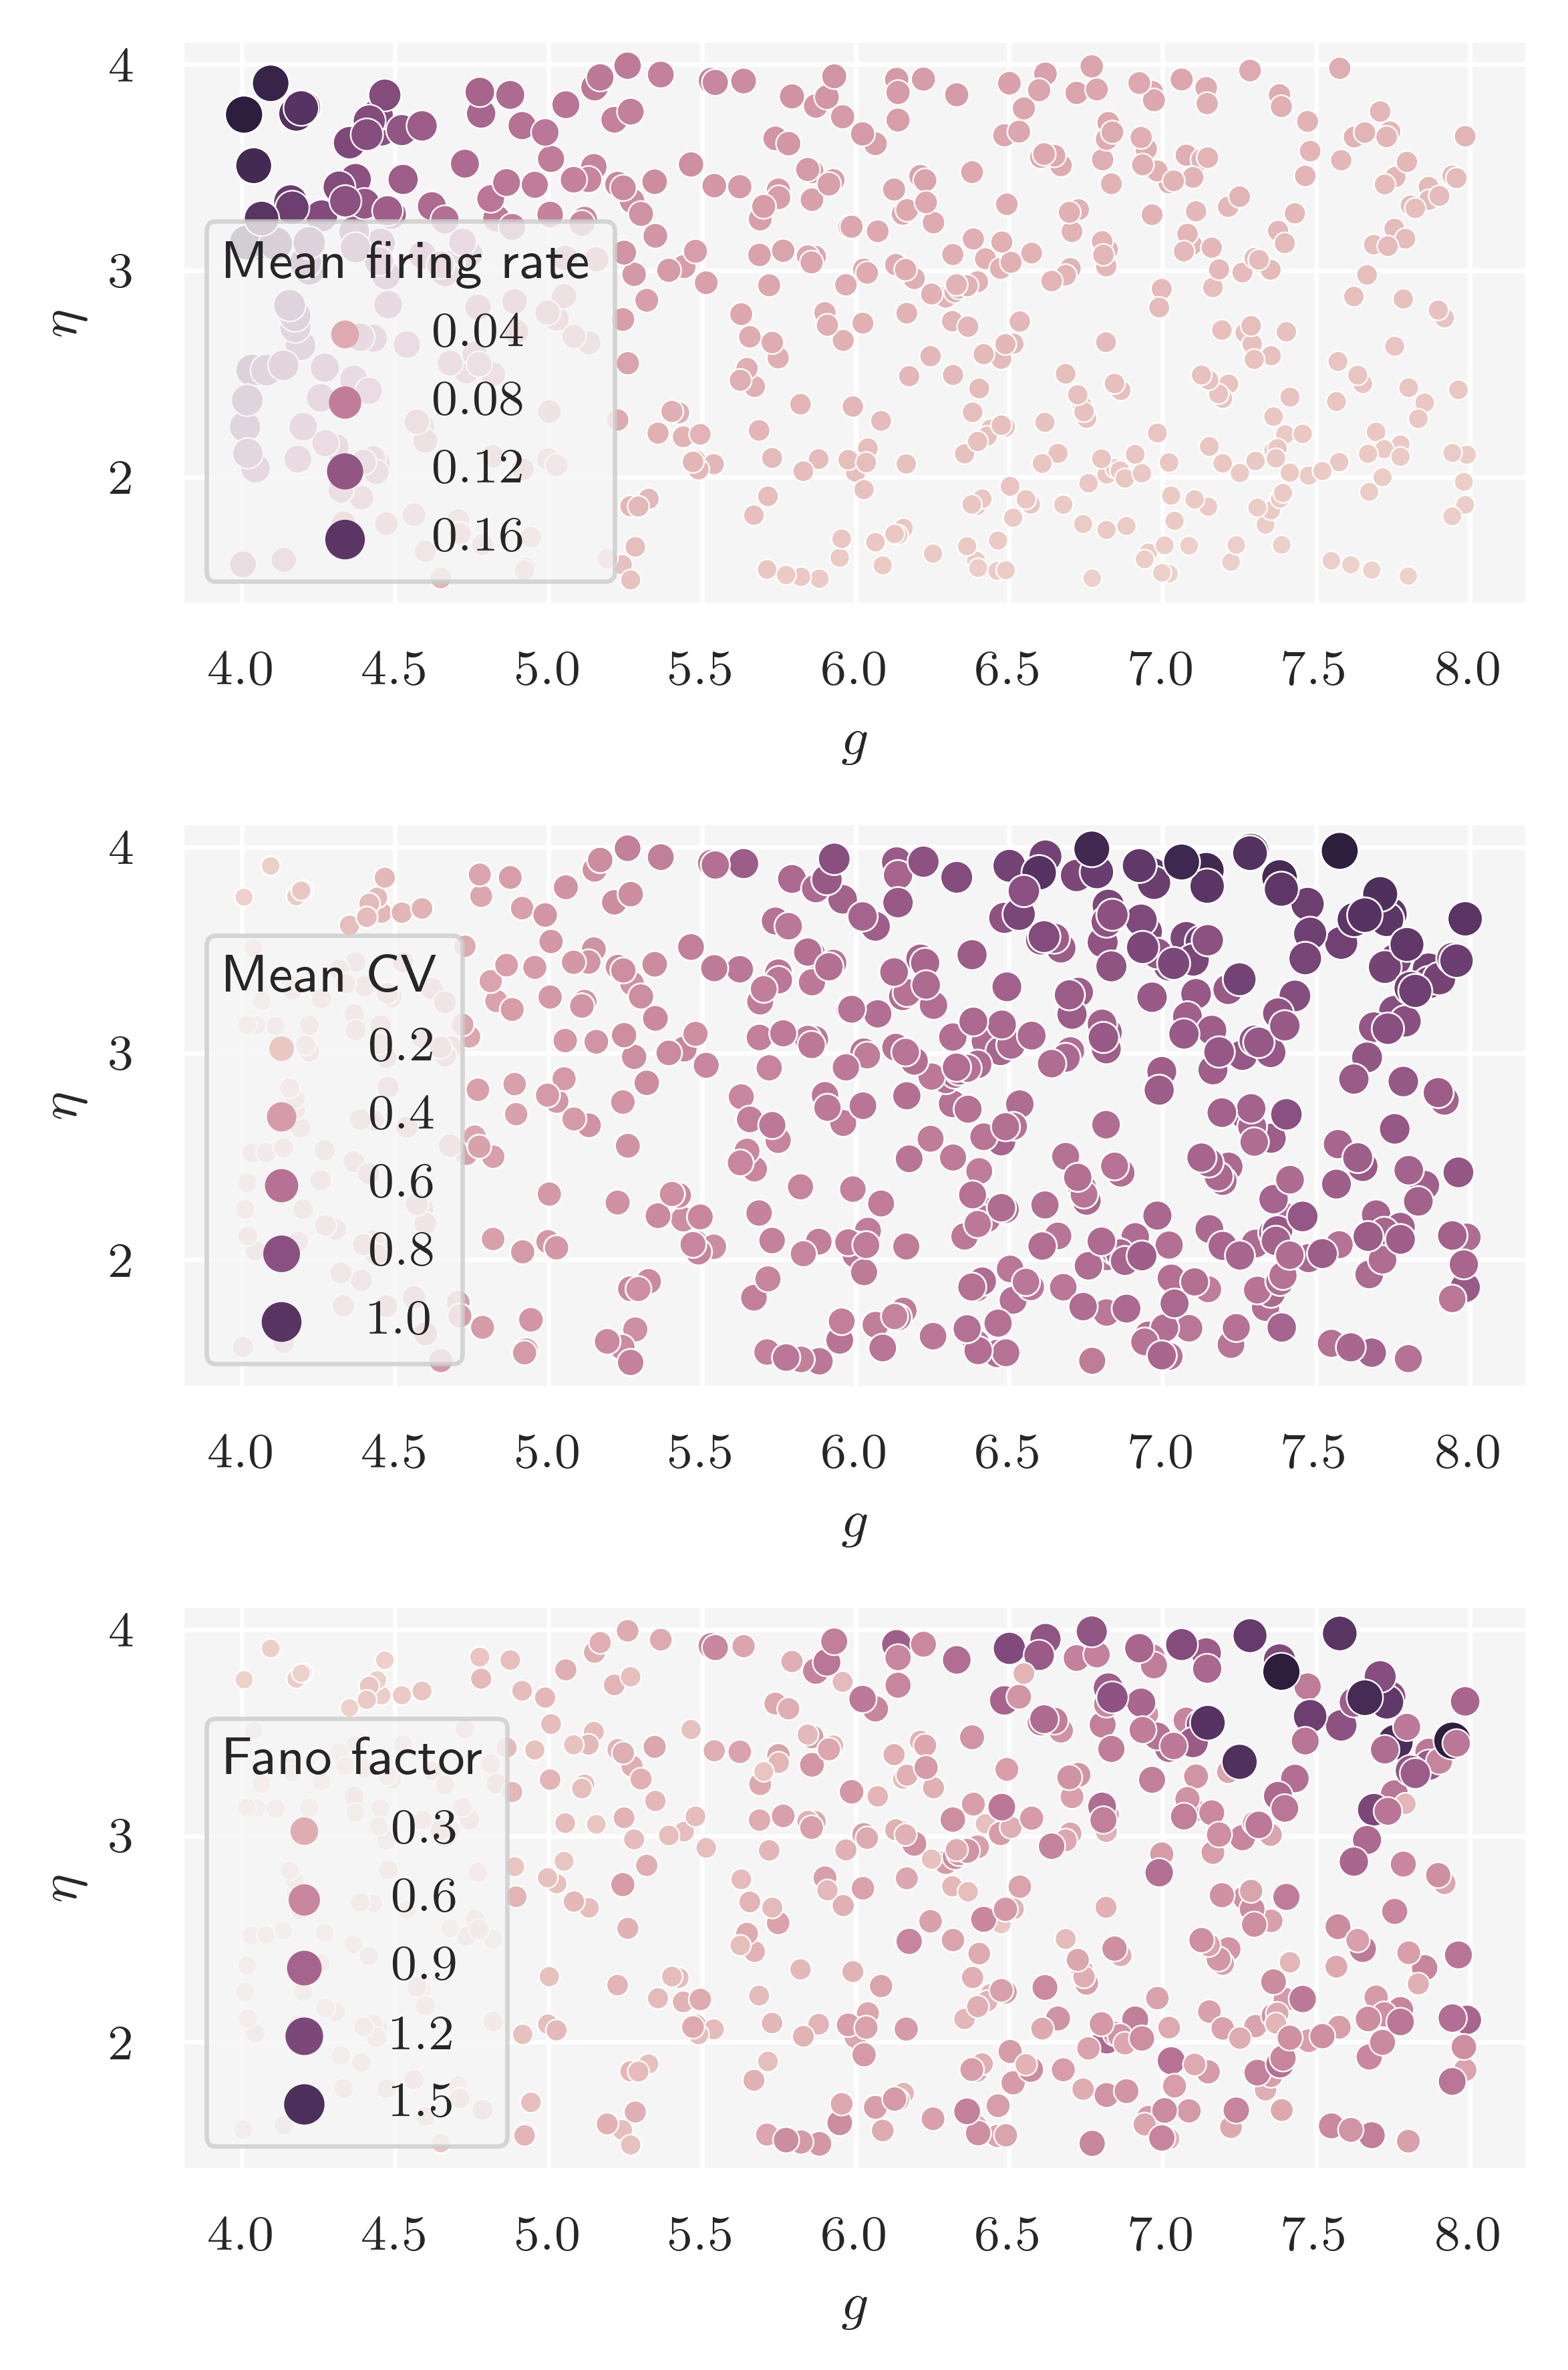

In [58]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(4, 6), tight_layout=True, dpi=300)

# Mean firing rate
sns.scatterplot(data=df_stats, 
                x=r"$g$", 
                y=r"$\eta$", 
                hue="Mean firing rate",
                size="Mean firing rate",
                ax=axes[0]
               )


# Mean CV
sns.scatterplot(data=df_stats, 
                x=r"$g$", 
                y=r"$\eta$", 
                hue="Mean CV",
                size="Mean CV",
                ax=axes[1]
               )

# Fano factor
sns.scatterplot(data=df_stats, 
                x=r"$g$", 
                y=r"$\eta$", 
                hue="Fano factor",
                size="Fano factor",
                ax=axes[2]
               )

fig.savefig(fig_path('brunel_sum_stats.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

### Correlation

In [59]:
selected_columns = df[['$\eta$', '$g$', 'mean_firing_rate', 'mean_cv', 'fanofactor']]
df_stats = selected_columns.copy()
df_stats.rename(columns={"mean_firing_rate": "Mean firing rate",
                   "mean_cv": "Mean CV",
                   "fanofactor": "Fano factor"
                  },
          inplace=True
         )

df_stats

,$\eta$,$g$,Mean firing rate,Mean CV,Fano factor
0,2.139653,6.040061,0.023944,0.549996,0.341667
1,1.768176,7.335284,0.011611,0.615821,0.283333
2,3.504035,5.147253,0.072833,0.443488,0.188276
3,3.067462,5.867245,0.043278,0.569711,0.323256
4,2.244444,4.588072,0.060722,0.353803,0.085153
...,...,...,...,...,...
1995,2.123932,4.667643,0.053667,0.379671,0.106657
1996,3.668498,4.704150,0.103167,0.325364,0.147708
1997,2.725004,7.344014,0.024000,0.722976,0.628891
1998,1.808409,6.152027,0.018000,0.568184,0.324504


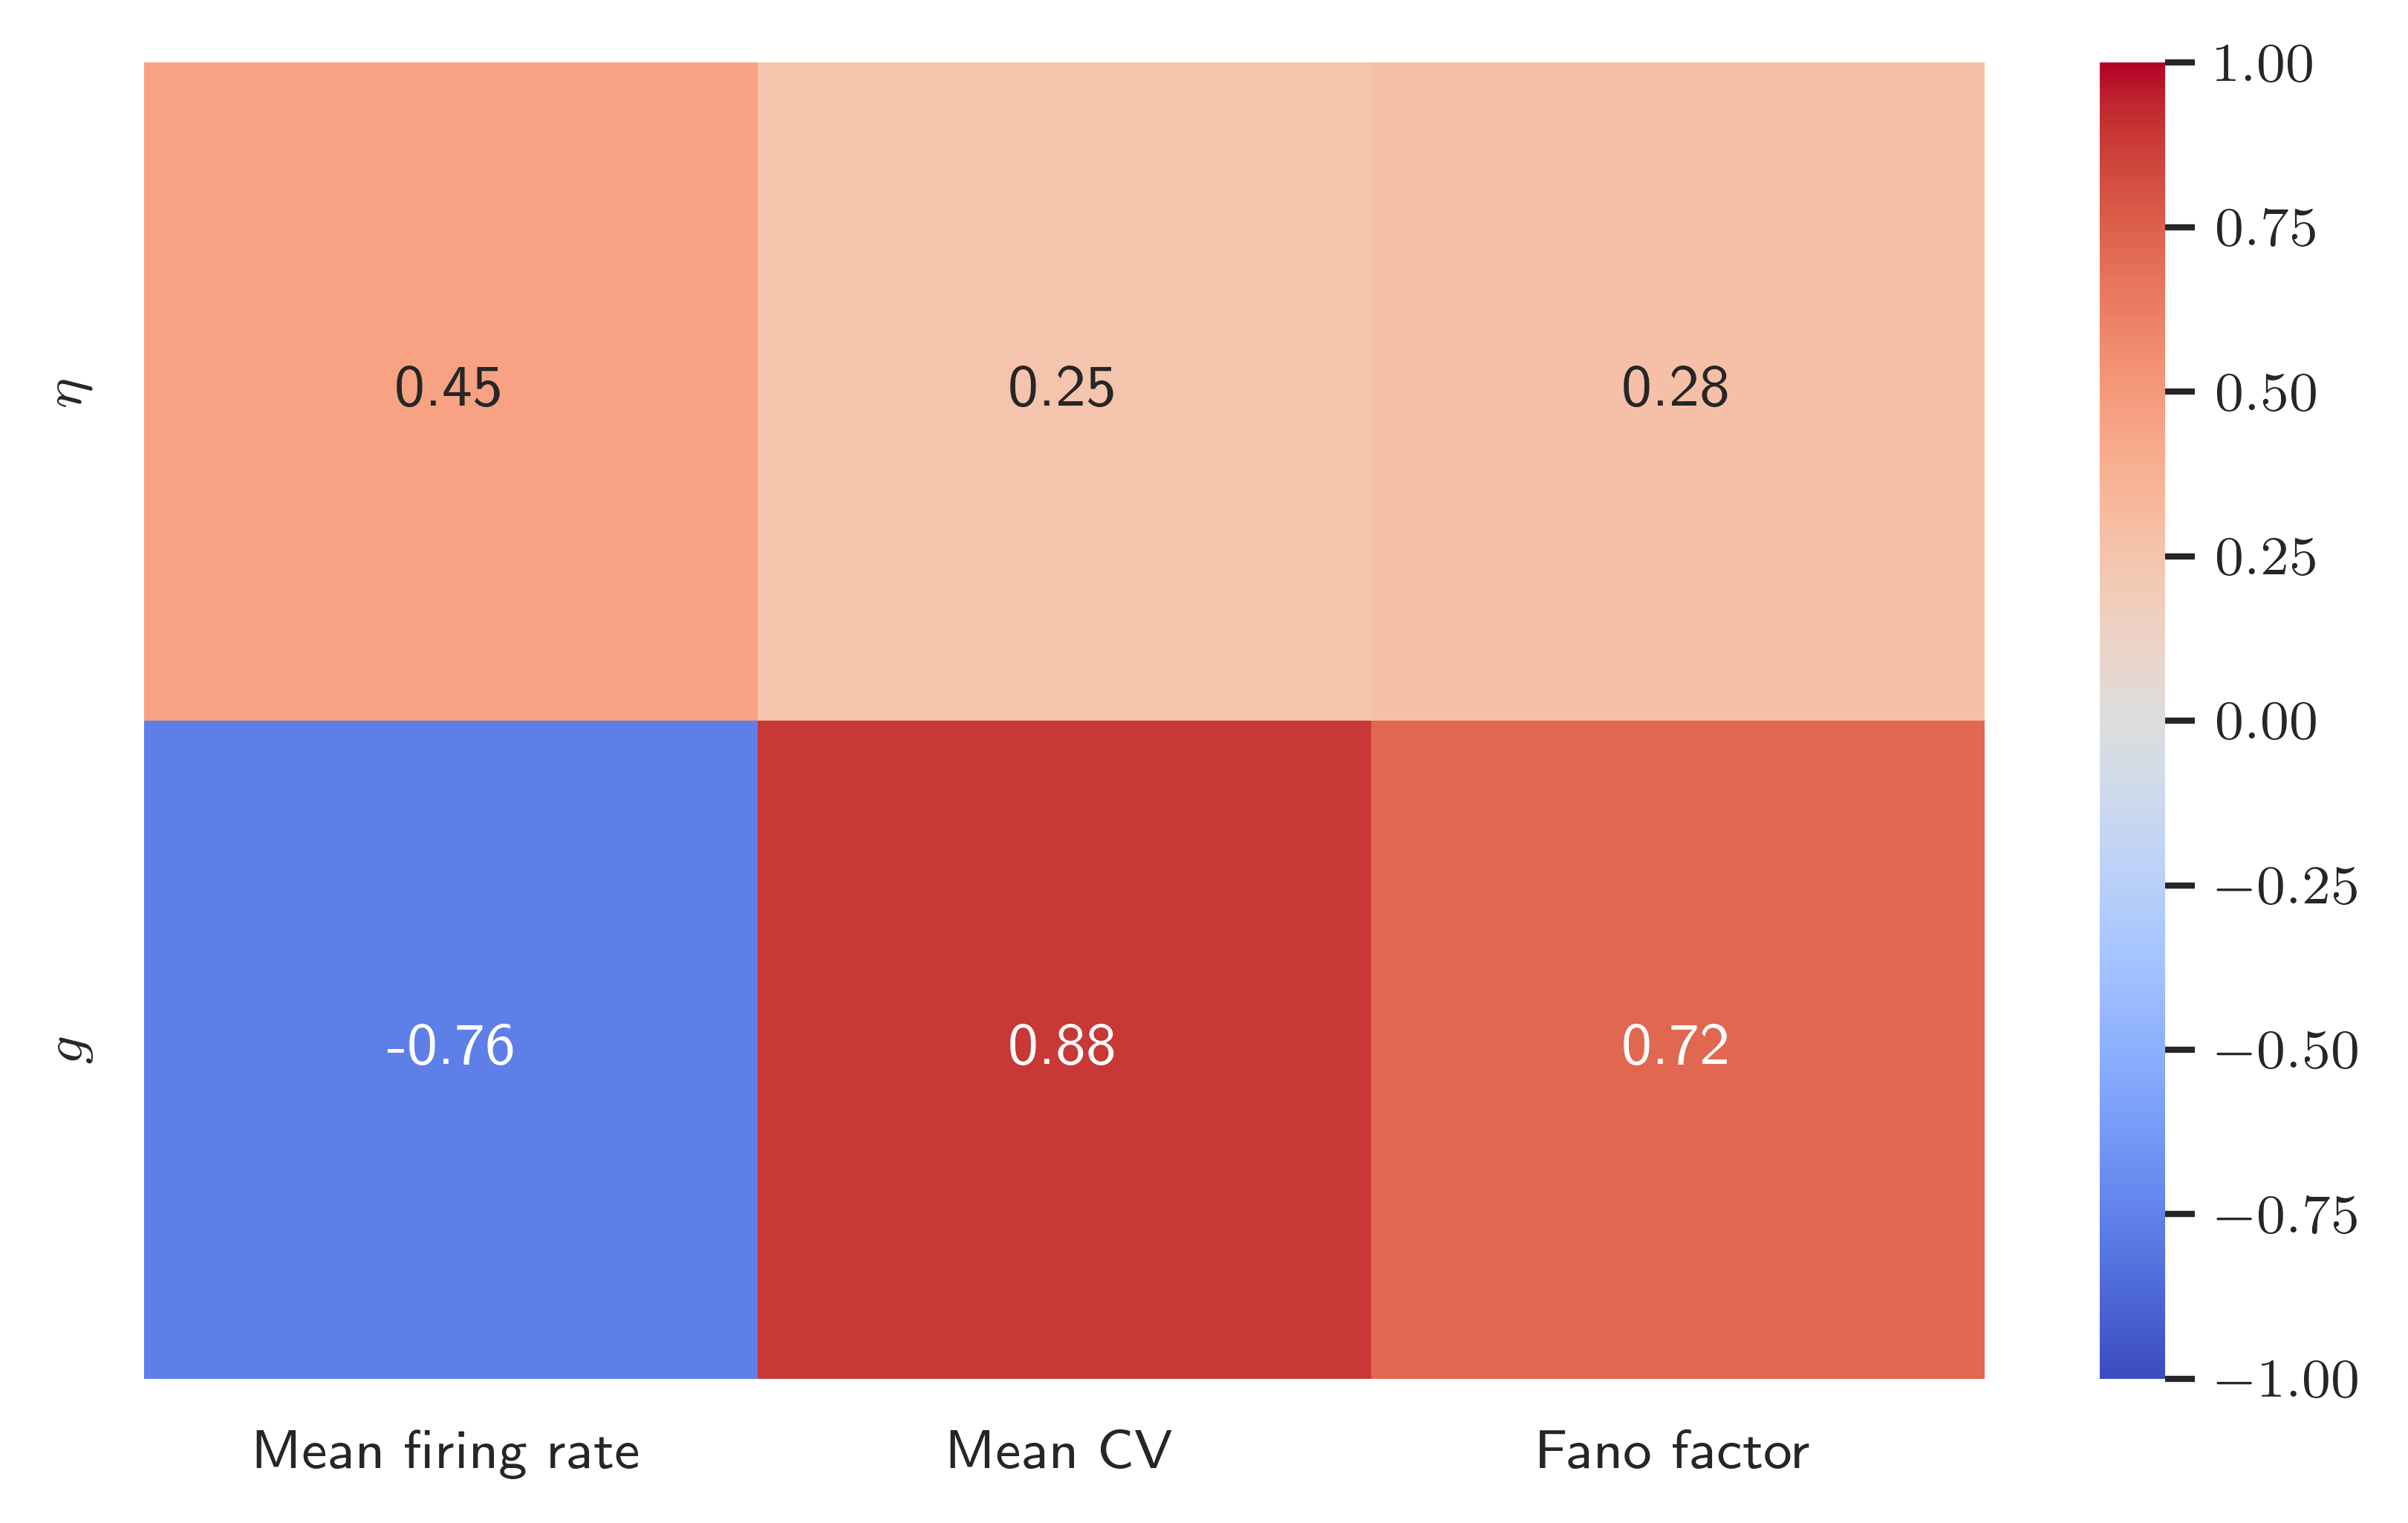

In [60]:
corr = df_stats.corr()

corr.drop(r"$g$", axis=1, inplace=True)
corr.drop(r"$\eta$", axis=1, inplace=True)
corr.drop("Mean firing rate", axis=0, inplace=True)
corr.drop("Mean CV", axis=0, inplace=True)
corr.drop("Fano factor", axis=0, inplace=True)

fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)
sns.heatmap(corr, ax=ax, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

fig.savefig(fig_path('brunel_sum_stats_corr.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

### Compute weights

In [61]:
weights = []
for col in corr.columns:
    r_eta = corr[col].iloc[0]
    r2_eta = r_eta**2 
    
    r_g = corr[col].iloc[1]
    r2_g = r_g**2 
    
    weight = np.mean([r2_eta, r2_g])
    weights.append(weight) 
    
df_weights = pd.DataFrame(data=weights,
                          columns=["Weight"],
                          index=corr.columns
                         )

# ensure that weights sum to 1
df_weights /= df_weights["Weight"].sum()

df_weights

,Weight
Mean firing rate,0.354215
Mean CV,0.378770
Fano factor,0.267015


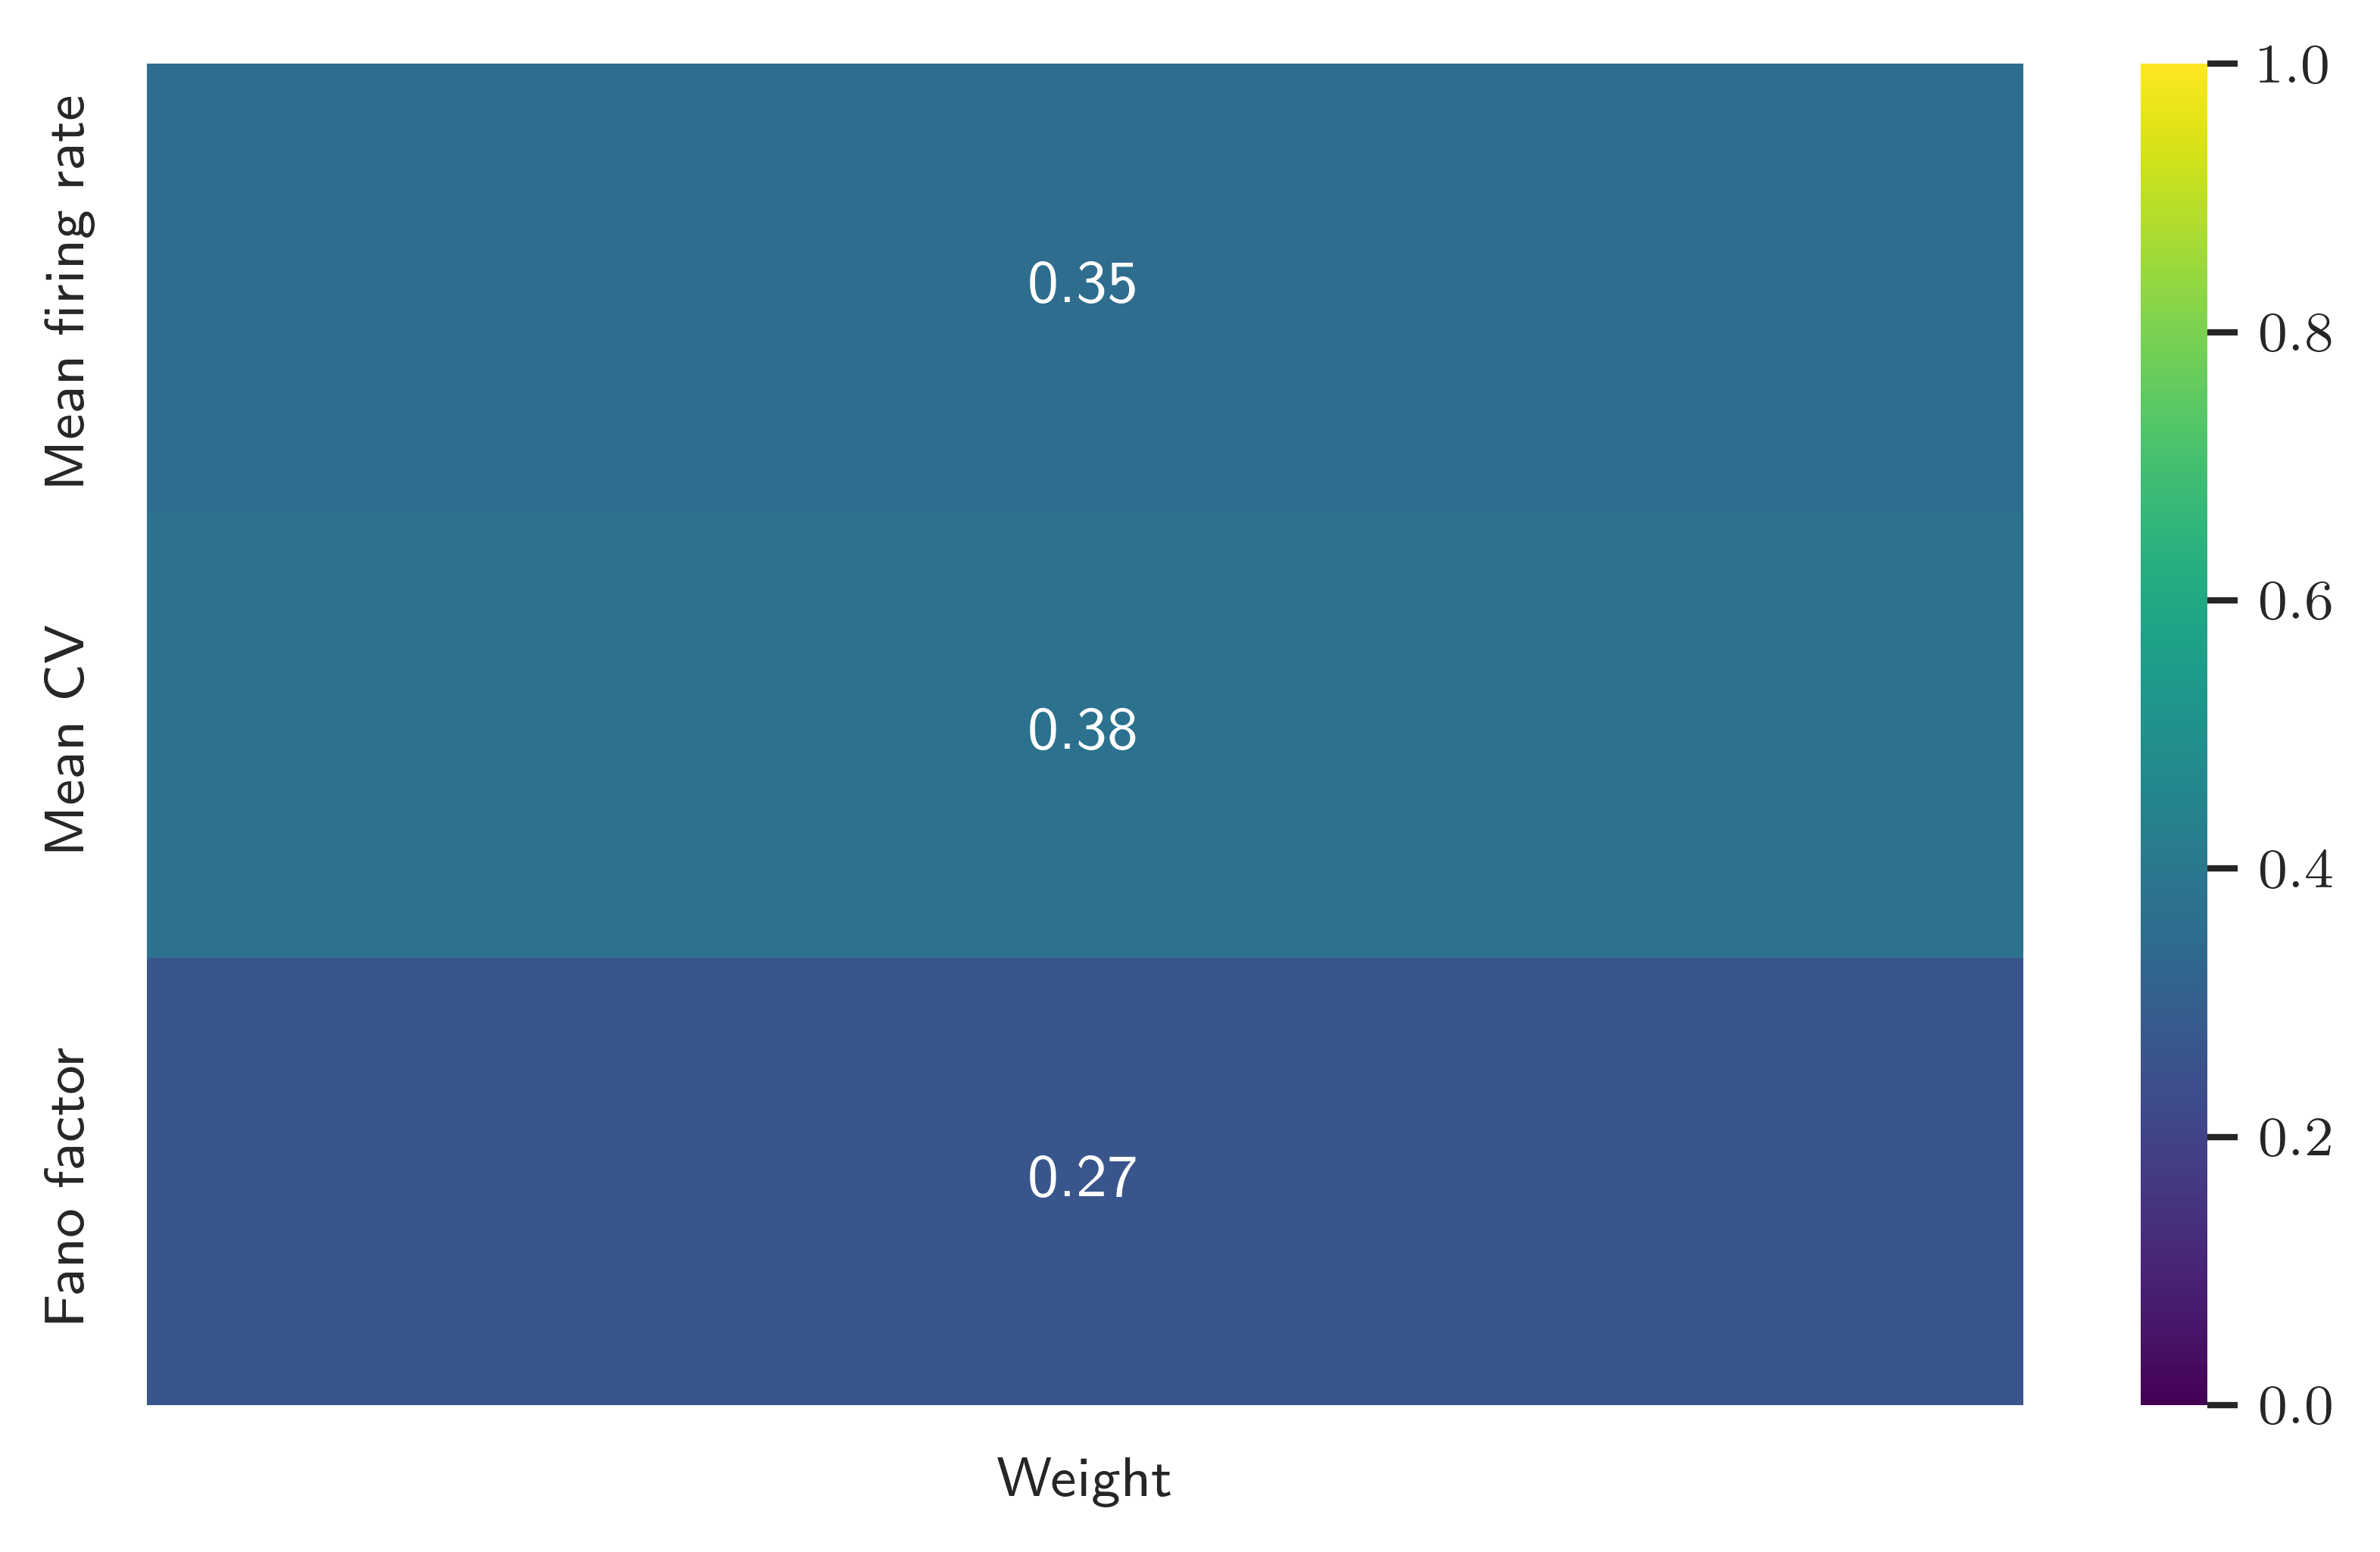

In [62]:
fig, ax = plt.subplots(figsize=fs, tight_layout=True, dpi=300)
sns.heatmap(df_weights, ax=ax, annot=True, cmap='viridis', vmin=0, vmax=1)

fig.savefig(fig_path('brunel_sum_stats_weights.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

### Scale

In [63]:
def sd(a, axis=0):    
    """Standard deviation from the mean"""
    a = np.asarray(a, dtype=float)
    a[a == np.inf] = np.NaN
    sd = np.sqrt(np.nanmean(np.abs(a - np.nanmean(a, axis=axis))**2, axis=axis))
    return sd

In [64]:
df = pd.read_csv('data/brunel_ai_data.csv')
s_stats = ["mean_firing_rate",  # rate estimation
           "mean_cv",           # spike interval statistic
           "fanofactor"         # statistic across spike trains
           ]
sum_stats = df[s_stats].to_numpy()
print(sum_stats)

[[0.02394444 0.54999643 0.34166667]
 [0.01161111 0.61582063 0.28333333]
 [0.07283333 0.44348815 0.18827586]
 ...
 [0.024      0.72297627 0.62889126]
 [0.018      0.56818381 0.32450425]
 [0.0175     0.76048784 0.44719101]]


In [65]:
stat_scale = sd(sum_stats)
print(stat_scale)

[0.03473533 0.20253095 0.33193481]


## Inference on simulation 

### Distance metric

In [66]:
def distance(s_sim, s_obs, weight=1., scale=1.):
    """Weighted Euclidean distance."""

    s_sim = np.asarray(s_sim, dtype=float)
    s_obs = np.asarray(s_obs, dtype=float)

    q = np.sqrt(weight) * (s_sim - s_obs) / scale
    dist = np.linalg.norm(q, ord=2)

    return dist

### Observed summary statistics

In [67]:
# observation

spiketrains = load_spiketrain('data/obs_ai_data.pkl')

# statistics calculator
s_stats = ["mean_firing_rate",  # rate estimation
           "mean_cv",           # spike interval statistic
           "fanofactor"         # statistic across spike trains
           ]

t_start = 100. * pq.ms
t_stop = T * pq.ms

sts = nm.statistics.SpikeTrainStats(stats=s_stats,
                                    t_start=t_start,
                                    t_stop=t_stop
                                    )

s_obs = sts(spiketrains)
print(s_obs)

[0.03661111111111111, 0.42506007658105566, 0.23413793103448277]


### Summary statistics weights and scales

In [68]:
stat_weights = df_weights["Weight"].to_numpy()
stat_scale = sd(sum_stats)
print(stat_weights)
print(stat_scale)

[0.3542154  0.37876988 0.26701472]
[0.03473533 0.20253095 0.33193481]


### Compute distances

In [69]:
distances = []
for s_sim in sum_stats:
    dist = distance(s_sim, s_obs, weight=stat_weights, scale=stat_scale)
    distances.append(dist)

### Find threshold as p-quantile of distances

In [70]:
quantile = 0.5 

distances = np.array(distances, dtype=np.float64)
epsilon = np.nanquantile(distances, quantile)

print(epsilon)

0.8182656923377771


### Accept/reject simulations

In [71]:
df_thetas = pd.read_csv('data/brunel_ai_data.csv')
thetas = df_thetas[["eta", "g"]].to_numpy()
print(thetas)

[[2.13965294 6.04006082]
 [1.76817597 7.33528368]
 [3.50403535 5.14725286]
 ...
 [2.72500387 7.34401354]
 [1.80840922 6.15202658]
 [2.55287539 7.7567157 ]]


In [72]:
# acceptance criterion
is_accepted = distances < epsilon
print(is_accepted)

[ True  True  True ... False  True False]


In [73]:
# accepted simulations
thetas_accepted = thetas[is_accepted]
dist_accepted = distances[is_accepted]
sum_stats_accepted = sum_stats[is_accepted]

In [74]:
print(is_accepted.sum().item())
print(thetas.shape)
print(thetas_accepted.shape)
print(dist_accepted.shape)
print(sum_stats_accepted.shape)

1000
(2000, 2)
(1000, 2)
(1000,)
(1000, 3)


### Create DataFrame with original posterior samples

In [75]:
param_names = [r'$\eta$', r'$g$']
data_org = dict(zip(param_names, np.stack(thetas_accepted, axis=-1)))
df_org = pd.DataFrame.from_dict(data_org)
df_org

,$\eta$,$g$
0,2.139653,6.040061
1,1.768176,7.335284
2,3.504035,5.147253
3,3.067462,5.867245
4,2.244444,4.588072
...,...,...
995,2.481909,5.423598
996,2.316365,4.900086
997,2.998135,5.871493
998,2.123932,4.667643


### Plot posterior

In [76]:
def compute_rmspe(theta_true, theta_pred):
    """Root mean square percentage error (RMSPE)"""
    rmspe = np.sqrt(np.mean(np.square((theta_true - theta_pred) / theta_true)))
    return rmspe * 100

def compute_point_est(theta, density, point_estimate):
    """Compute point estimate"""
    if point_estimate == "mean":
        p_est = theta.mean()
        handle = "mean"
    elif point_estimate == "median":
        p_est = np.median(theta)
        handle = "median"
    elif point_estimate == "map":
        idx = np.argmax(density)
        p_est = theta[idx]
        handle = "MAP"
    return p_est, handle

def compute_hdi(theta, hdi_prob):
    """Highest (posterior) density interval"""
    theta = theta.flatten()
    n = len(theta)
    theta = np.sort(theta)
    interval_idx_inc = int(np.floor(hdi_prob * n))
    n_intervals = n - interval_idx_inc
    interval_width = np.subtract(theta[interval_idx_inc:],
                                 theta[:n_intervals],
                                 dtype=np.float_
                                 )
    min_idx = np.argmin(interval_width)
    hdi_min = theta[min_idx]
    hdi_max = theta[min_idx + interval_idx_inc]
    return (hdi_min, hdi_max)


def plot_posterior(df, theta_name, theta_true, point_estimate='map', hdi_prob=0.95, ax=None):
    
    if ax is None:
        ax = plt.gca()
        
    xdata = df[theta_name].to_numpy() 
    theta_true_ary = np.ones(len(xdata.flatten())) * theta_true
    rmspe = compute_rmspe(theta_true_ary, xdata)
    
    sns.kdeplot(data=df,
                x=theta_name,
                color='C0',
                label=f"Posterior RMSPE: {rmspe:.2f}\%",
                ax=ax
            )

    ax.axvline(theta_true,
               ymax=0.3,
               color='C3',
               label=fr"$\theta_\mathrm{{true}}: {theta_true}$"
              )
    kdeline = ax.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()

    p_est, p_est_handle = compute_point_est(xs, ys, point_estimate)

    hdi_min, hdi_max = compute_hdi(xdata, hdi_prob=hdi_prob)

    ax.vlines(
        p_est,
        0,
        np.interp(p_est, xs, ys),
        color='b',
        ls=':',
        label=fr"$\hat{{\theta}}_\mathrm{{{p_est_handle}}}: {p_est:.3f}$"
    )

    ax.fill_between(
        xs,
        0,
        ys,
        facecolor='lightblue',
        alpha=0.3
    )

    ax.fill_between(
        xs,
        0,
        ys,
        where=(hdi_min <= xs) & (xs <= hdi_max),
        interpolate=True,
        facecolor='steelblue',
        alpha=0.3,
        label=f"{hdi_prob*100}\% HDI: [{hdi_min:.3f}, {hdi_max:.3f}]"
    )

    handles, labels = ax.get_legend_handles_labels()

    ax.set(yticks=[])

    ax.legend(
        handles,
        labels,
        loc='center left',
        bbox_to_anchor=(1.04, 0.5),
        fancybox=True,
        borderaxespad=0.1,
        ncol=1,
        frameon=False
    )
    
    
def plot_joint(df, theta1_name, theta2_name, theta1_true=None, theta2_true=None, levels=6, alpha=0.3, height=4, **kwargs):

    g = sns.jointplot(
        data=df,
        x=theta1_name,
        y=theta2_name,
        kind="kde",
        fill=True,
        height=height,
        **kwargs
    )

    g.plot_joint(
        sns.kdeplot,
        color="k",
        levels=levels,
        alpha=alpha
    )

    if theta1_true is not None and theta2_true is not None:
        g.ax_joint.plot([theta1_true], [theta2_true], 'ro')
        g.ax_joint.axvline(theta1_true, color='r', ls=":")
        g.ax_joint.axhline(theta2_true, color='r', ls=":")
        g.ax_marg_x.axvline(theta1_true, color='r')
        g.ax_marg_y.axhline(theta2_true, color='r')

    return g

In [77]:
# ground truth
eta_true = 2.
g_true = 5.

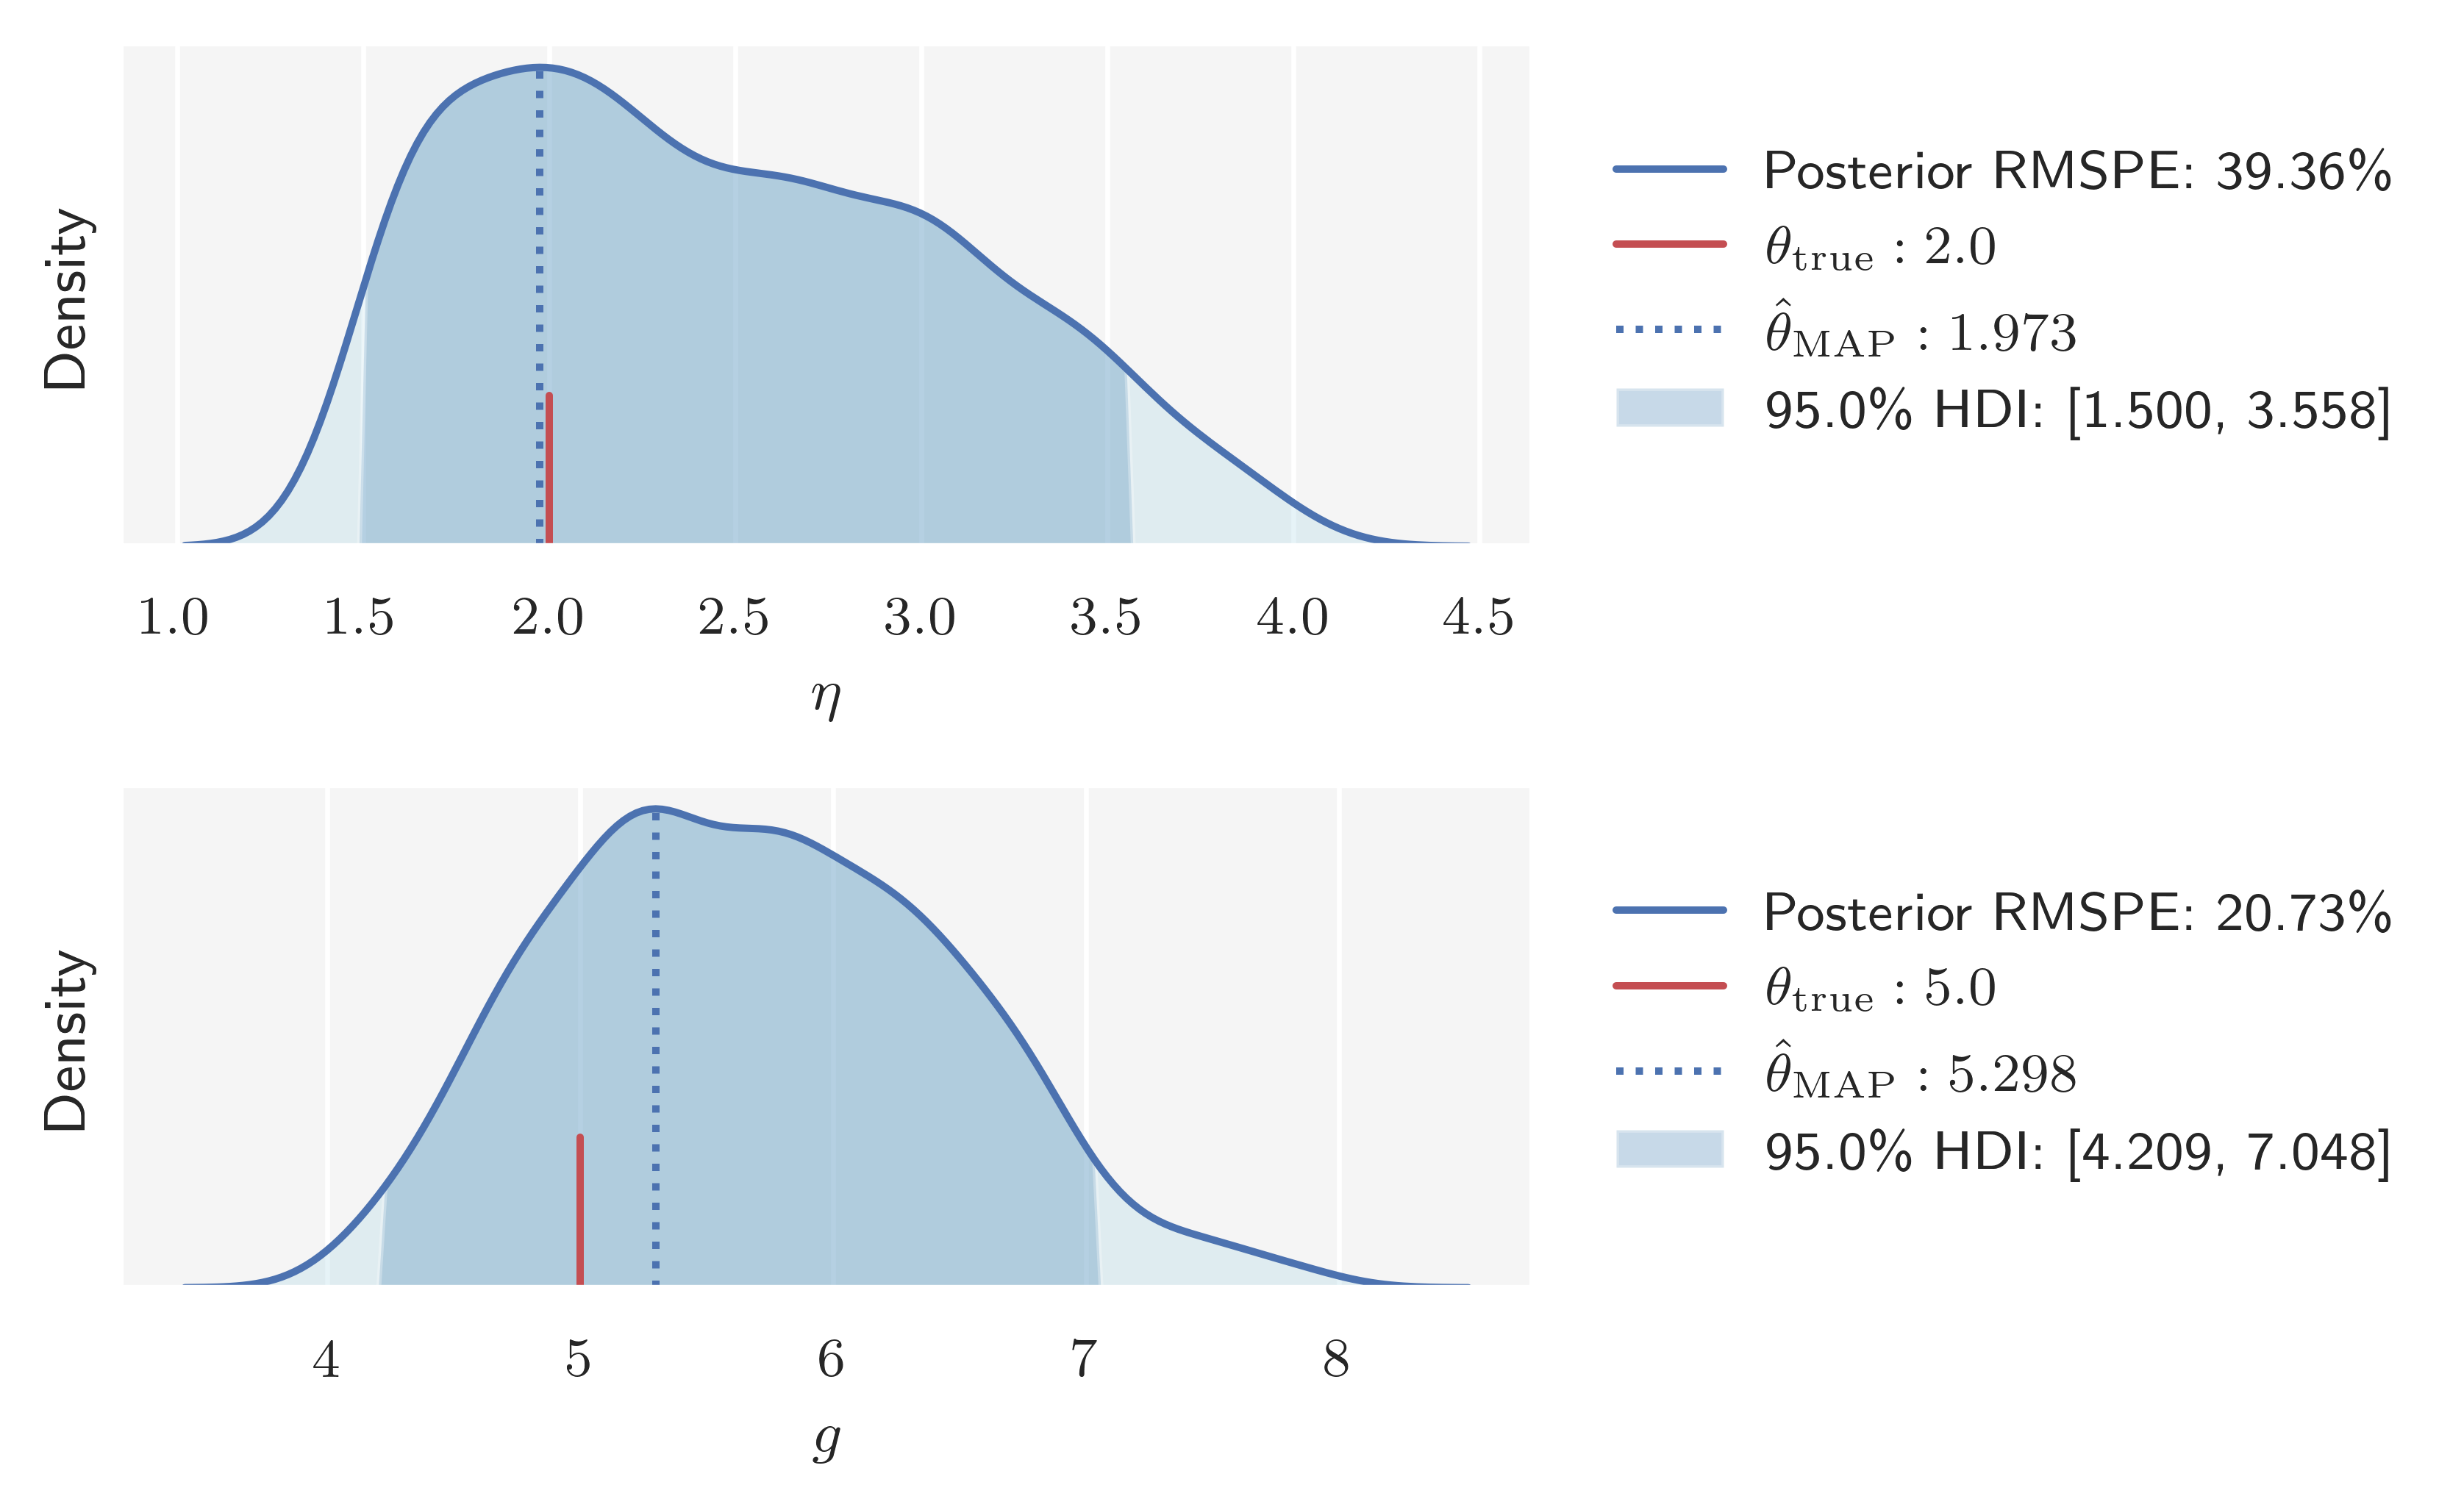

In [78]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=fs, tight_layout=True, dpi=300)
plot_posterior(df_org, r'$\eta$', point_estimate='map', theta_true=eta_true, ax=axes[0])
plot_posterior(df_org, r'$g$', point_estimate='map', theta_true=g_true, ax=axes[1])

fig.savefig(fig_path('brunel_posterior_org.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

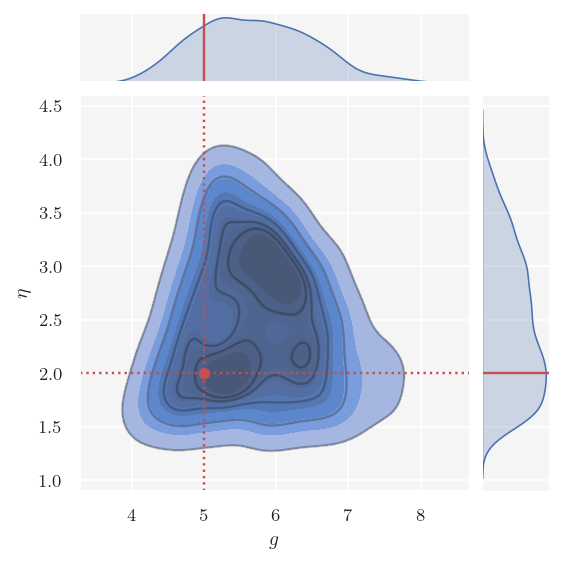

In [79]:
g = plot_joint(df_org, r'$g$', r'$\eta$', g_true, eta_true, height=4)

g.savefig(fig_path('brunel_joint_posterior_org.pdf'), 
          format='pdf', 
          dpi=300, 
          bbox_inches='tight'
         )

### Regression Adjustment

In [80]:
import copy

In [81]:
def epkov_kernel(d, h):
    """Epanechnikov smoothing kernel function"""
    return (1.0 - (d * d) / (h * h)) * (d < h)

In [82]:
# data (design matrix)
X = copy.deepcopy(sum_stats_accepted)

# scale and apply weights
factor = stat_weights / stat_scale
X *= factor

if X.ndim == 1:
    X = X.reshape(-1, 1)

# augment with column of ones
X = np.c_[np.ones(X.shape[0]), X]

# target
thetas = copy.deepcopy(thetas_accepted)

# transform:
thetas = np.log(thetas)

# smoothing kernel weights
kernel_weights = np.array([epkov_kernel(d, epsilon) for d in dist_accepted])

# Weight matrix
W = np.diag(kernel_weights) 

# compute coefficients (pinv = pseudo-inverse)
#coef = np.linalg.pinv(X.T @ X)  @ X.T @ thetas
coef = np.linalg.pinv(X.T @ (W @ X)) @ X.T @ (W @ thetas)
alpha = coef[0]
beta = coef[1:]

# adjust posterior samples
s_sim_reg = sum_stats_accepted * factor
s_obs_reg = s_obs * factor
correction = (s_sim_reg - s_obs_reg) @ beta

thetas_adjusted = np.exp(np.log(thetas_accepted) - correction)

param_names = [r'$\eta$', r'$g$']
data_reg = dict(zip(param_names, np.stack(thetas_adjusted, axis=-1)))
df_reg = pd.DataFrame.from_dict(data_reg)
df_reg

,$\eta$,$g$
0,1.950856,5.137448
1,1.706006,5.749084
2,1.809624,5.195612
3,1.918451,4.956247
4,1.783624,5.127361
...,...,...
995,2.164441,5.182614
996,2.014043,5.135027
997,2.045160,5.069623
998,1.786450,5.027610


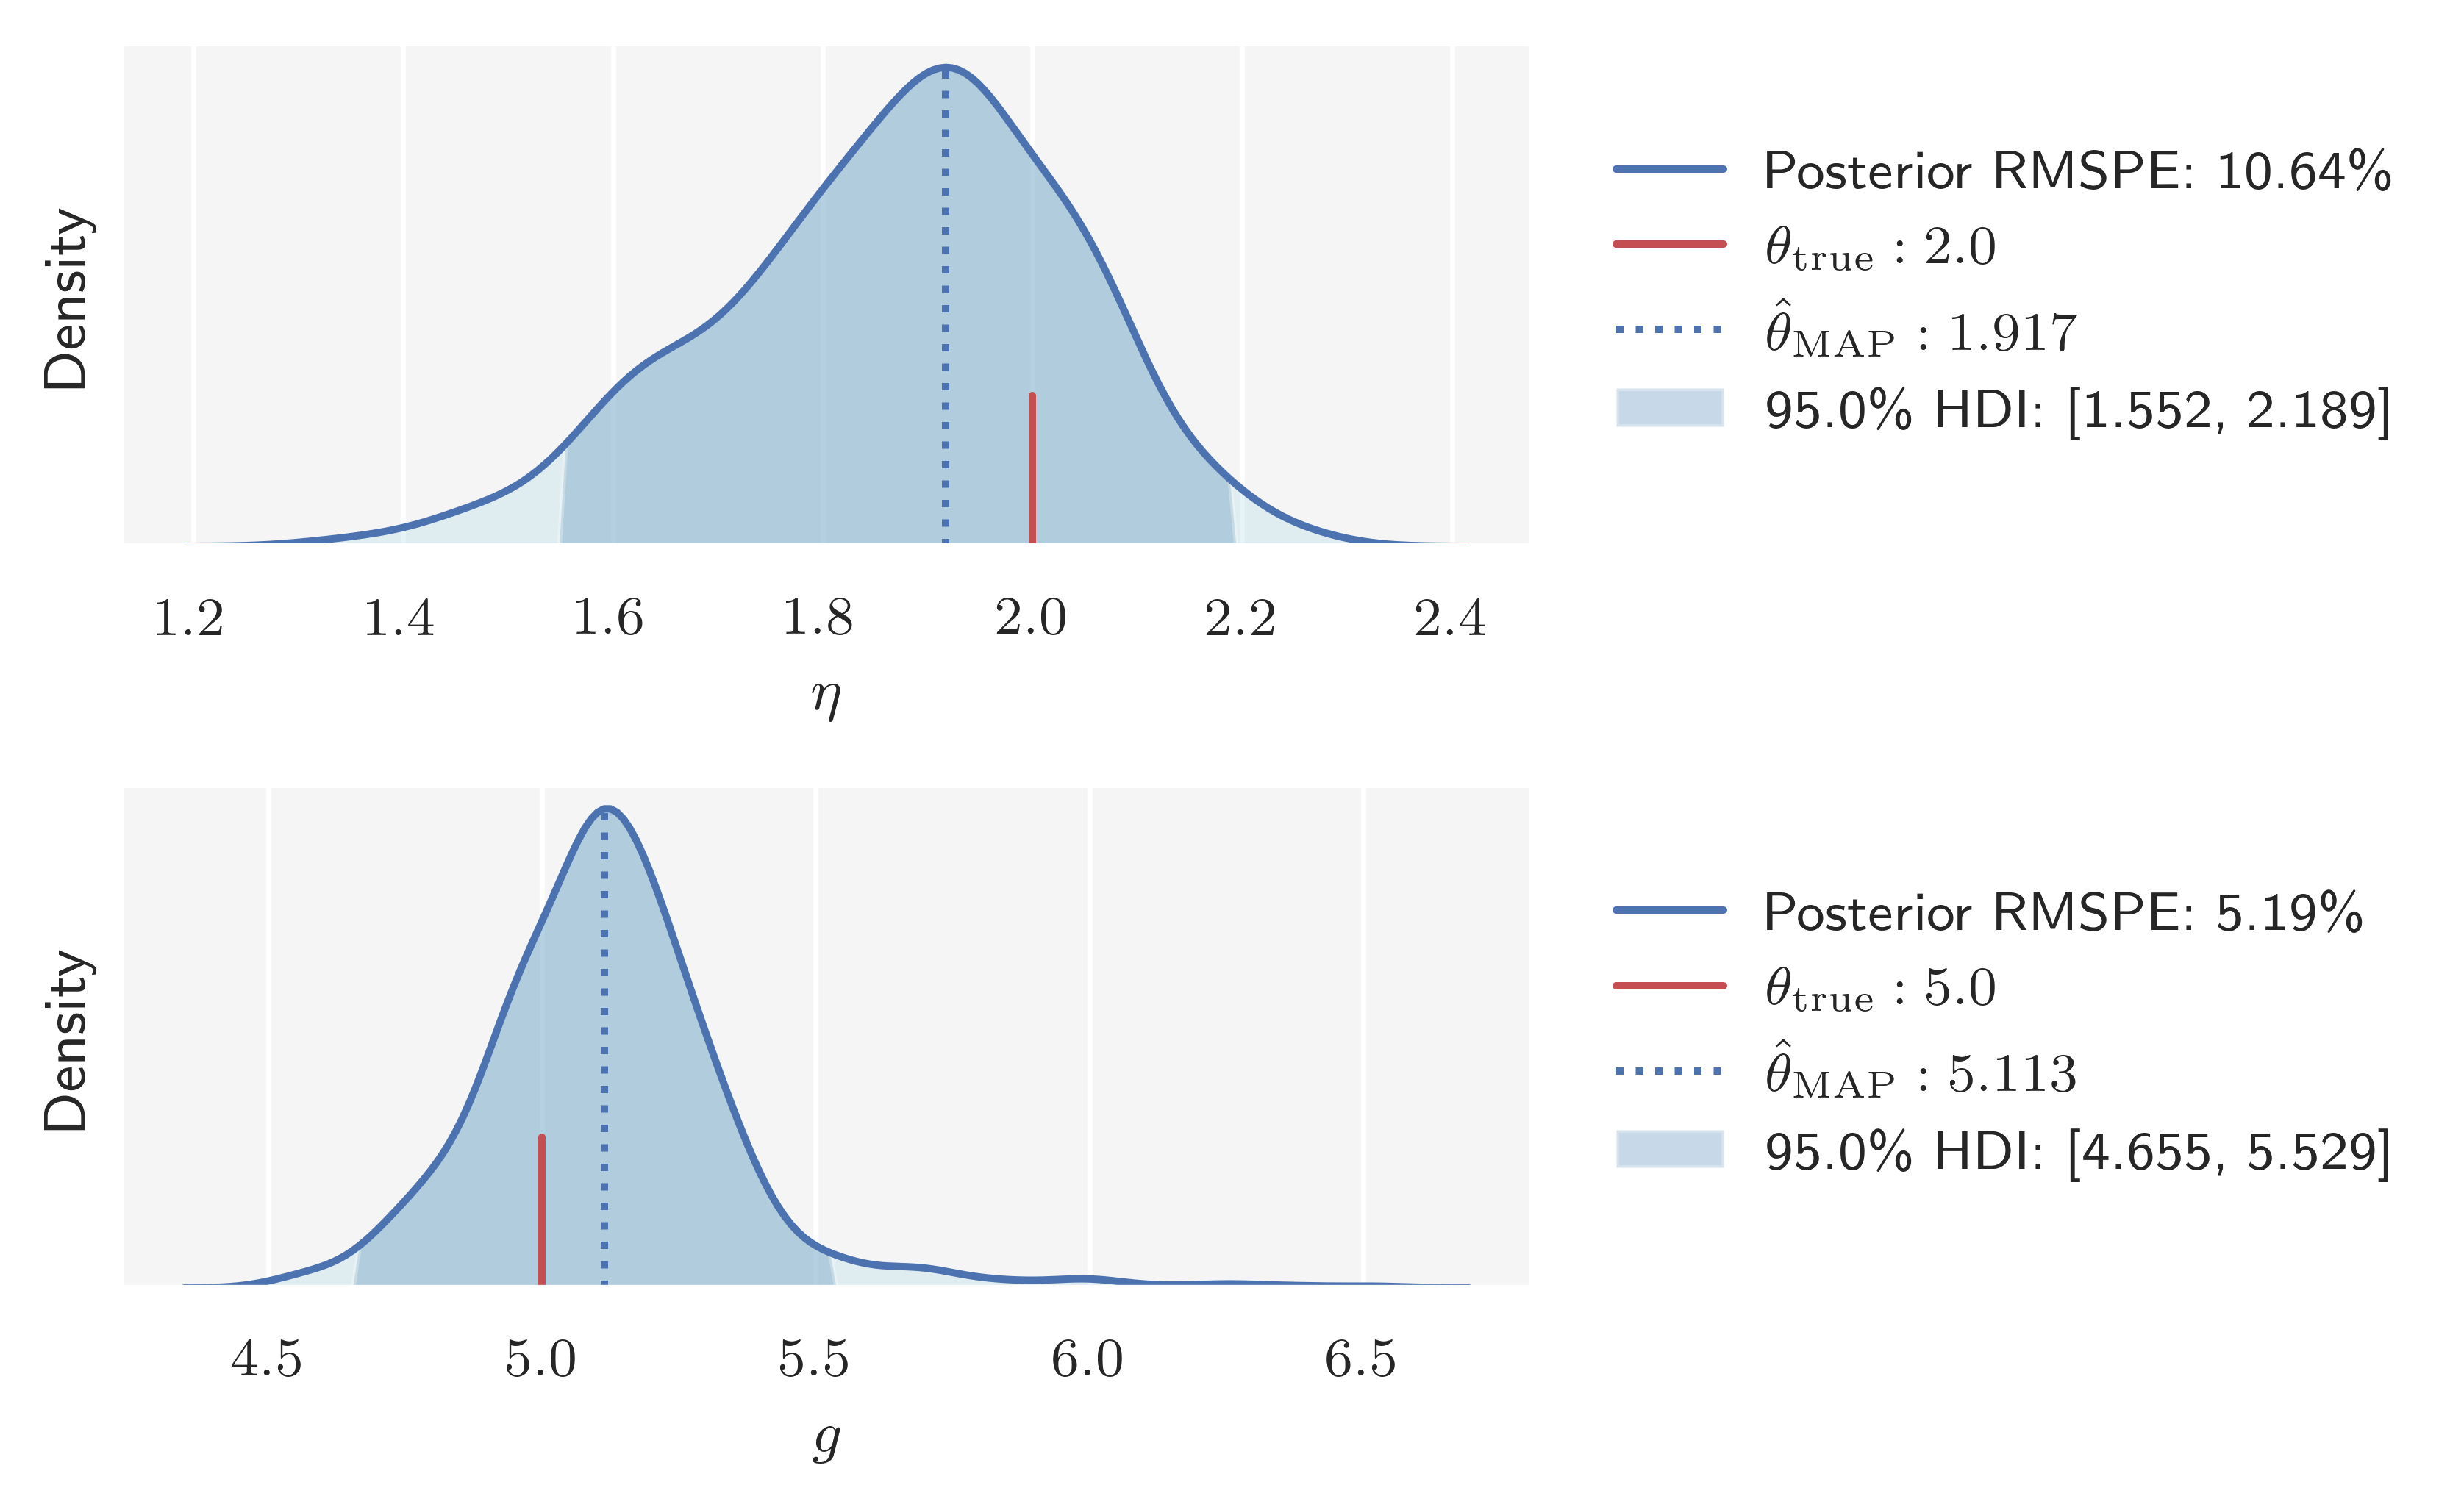

In [83]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=fs, tight_layout=True, dpi=300)
plot_posterior(df_reg, r'$\eta$', point_estimate='map', theta_true=eta_true, ax=axes[0])
plot_posterior(df_reg, r'$g$', point_estimate='map', theta_true=g_true, ax=axes[1])

fig.savefig(fig_path('brunel_posterior_reg.pdf'), 
            format='pdf', 
            dpi=300, 
            bbox_inches='tight'
           )

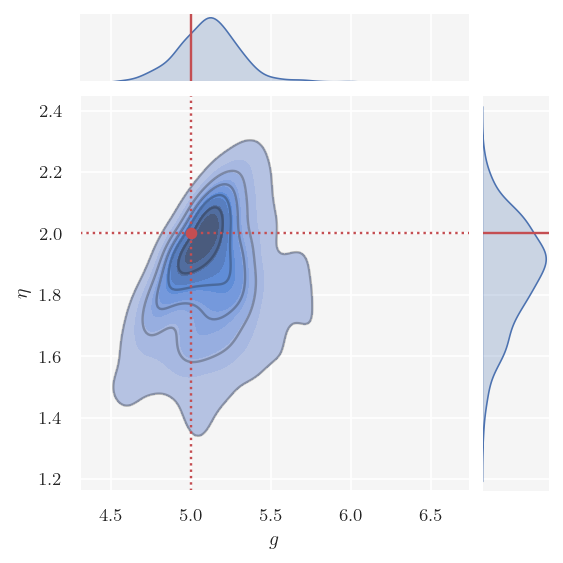

In [84]:
g = plot_joint(df_reg, r'$g$', r'$\eta$', g_true, eta_true, height=4)

g.savefig(fig_path('brunel_joint_posterior_reg.pdf'), 
          format='pdf', 
          dpi=300, 
          bbox_inches='tight'
         )

### Posterior predictive

In [85]:
# simulator
order = 2500    # -> NE=10,000 ; NI=2500 ; N_tot=12,500 ; CE=1000 ; CI=250
epsilon = 0.1   # connection probability
D = 1.5         # synaptic delay (ms)
T = 1000        # simulation time (ms)
N_rec = 20      # record output from N_rec neurons
n_type = 'exc'  # record excitatory spike trains
J = 0.1         # excitatory synapse weight (mV)

# NEST settings
threads = 16        # number of threads to use in simulation
print_time = False  # print simulated time or not

# simulator model
bnet = nm.models.BrunelNet(order=order,
                           epsilon=epsilon,
                           D=D,
                           J=J,
                           T=T,
                           N_rec=N_rec,
                           n_type=n_type,
                           print_time=print_time,
                           threads=threads
                           )

In [86]:
def hh_posterior_predictive(obs_data, simulator, thetas_pred, ax=None):
    if ax is None:
        ax = plt.gca()
        
    post_preds = np.array([hh(*theta) for theta in thetas_pred])
    mean_pred = np.mean(post_preds, axis=0)
    
    p1, = ax.plot(obs_data[1], obs_data[0], color='k', lw=1.0, zorder=1)
    
    for pred in post_preds:
        p2, = ax.plot(pred[1], pred[0], color='C0', alpha=0.2, zorder=0)
    
    p3, = ax.plot(mean_pred[1], mean_pred[0], color='C1', ls='--', dashes=(5, 5), lw=1.0, zorder=2)
    
    ax.set(xlabel="Time (ms)",
           ylabel="Membrane Potential (mV)"
          )
    
    ax.legend(
        [p1, p2, p3],
        ['Observation', 'Posterior predictive', 'Posterior predictive mean'],
        loc='center left',
        bbox_to_anchor=(1.04, 0.5),
        fancybox=True,
        borderaxespad=0.1,
        ncol=1,
        frameon=False
    )